## 1. 패키지 불러오기

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_regression

pd.set_option('max.columns', 100)

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

plt.rcParams['font.family'] = 'AppleGothic'
matplotlib.rcParams['axes.unicode_minus'] = False
plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings(action = 'ignore')

from scipy import stats

## 2. 데이터 불러오기

In [2]:
# 데이터 확인
raw_data = pd.read_csv('train.csv')

print('Shape of Data :', raw_data.shape, '\n')
print('-' * 50)
print(raw_data.info())

Shape of Data : (1460, 81) 

--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1

## 3. 결측치 처리

In [3]:
object_list = ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 
               'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 
               'PoolQC', 'Fence', 'MiscFeature']

# 원래 데이터를 보존하기 위해 새로운 DataFrame 생성
modify_data = raw_data.copy()

# 결측치를 의미하지 않는 값에 'No have' 채워넣기
for feature in object_list:
    null_data = modify_data[feature].isnull().sum()
    print('Number of null values of {} *Before Modify* :'.format(feature), null_data, '\n')
    
    modify_data.loc[modify_data[feature].isnull(), feature] = 'No have'
    
    null_data = modify_data[feature].isnull().sum()
    print('Number of null values of {} *After Modify* :'.format(feature), null_data)
    print('-' * 60)

Number of null values of Alley *Before Modify* : 1369 

Number of null values of Alley *After Modify* : 0
------------------------------------------------------------
Number of null values of BsmtQual *Before Modify* : 37 

Number of null values of BsmtQual *After Modify* : 0
------------------------------------------------------------
Number of null values of BsmtCond *Before Modify* : 37 

Number of null values of BsmtCond *After Modify* : 0
------------------------------------------------------------
Number of null values of BsmtExposure *Before Modify* : 38 

Number of null values of BsmtExposure *After Modify* : 0
------------------------------------------------------------
Number of null values of BsmtFinType1 *Before Modify* : 37 

Number of null values of BsmtFinType1 *After Modify* : 0
------------------------------------------------------------
Number of null values of BsmtFinType2 *Before Modify* : 38 

Number of null values of BsmtFinType2 *After Modify* : 0
---------------

In [4]:
print('Number of null values of GarageYrBlt *Before Modify* :', modify_data['GarageYrBlt'].isnull().sum(), '\n')

# 결측치 대체
modify_data.loc[modify_data['GarageYrBlt'].isnull(), 'GarageYrBlt'] = 0
print('Number of null values of GarageYrBlt *After Modify* :', modify_data['GarageYrBlt'].isnull().sum())

Number of null values of GarageYrBlt *Before Modify* : 81 

Number of null values of GarageYrBlt *After Modify* : 0


In [5]:
print('Number of null values of MasVnrType *Before* :', modify_data['MasVnrType'].isnull().sum(), '\n')
print('Number of null values of MasVnrArea *Before* :', modify_data['MasVnrArea'].isnull().sum(), '\n')
print('Number of null values of Electrical *Before* :', modify_data['Electrical'].isnull().sum(), '\n')

modify_data['MasVnrType'].fillna('None', inplace = True)
modify_data['MasVnrArea'].fillna(0, inplace = True)
modify_data['Electrical'].fillna(modify_data['Electrical'].mode()[0], inplace = True)

print('Number of null values of MasVnrType *After* :', modify_data['MasVnrType'].isnull().sum(), '\n')
print('Number of null values of MasVnrArea *After* :', modify_data['MasVnrArea'].isnull().sum(), '\n')
print('Number of null values of Electrical *After* :', modify_data['Electrical'].isnull().sum())

Number of null values of MasVnrType *Before* : 8 

Number of null values of MasVnrArea *Before* : 8 

Number of null values of Electrical *Before* : 1 

Number of null values of MasVnrType *After* : 0 

Number of null values of MasVnrArea *After* : 0 

Number of null values of Electrical *After* : 0


In [6]:
# 'LotFrontage' 변수의 결측치를 예측하기 위한 변수 추출
miss_list = ['Id', 'MSSubClass', 'MSZoning', 'LotShape', 'LotConfig', '1stFlrSF', 
             'BldgType', 'GrLivArea', 'LotArea', 'LotFrontage']

# 데이터 추출
miss_data = modify_data[miss_list]

print('Shape of miss_data :', miss_data.shape)
miss_data.head()

Shape of miss_data : (1460, 10)


,Id,MSSubClass,MSZoning,LotShape,LotConfig,1stFlrSF,BldgType,GrLivArea,LotArea,LotFrontage
0,1,60,RL,Reg,Inside,856,1Fam,1710,8450,65.0
1,2,20,RL,Reg,FR2,1262,1Fam,1262,9600,80.0
2,3,60,RL,IR1,Inside,920,1Fam,1786,11250,68.0
3,4,70,RL,IR1,Corner,961,1Fam,1717,9550,60.0
4,5,60,RL,IR1,FR2,1145,1Fam,2198,14260,84.0


In [7]:
outlier_id = miss_data[miss_data['LotFrontage'] > 300]['Id']

# 'LotFrontage' 변수의 값이 300 넘는 관측치 삭제
miss_data = miss_data[~miss_data['Id'].isin(outlier_id)]
miss_data.reset_index(drop = True, inplace = True)

# 'NewLotShape' 변수 생성
print('Shape of miss_data *Before Create* :', miss_data.shape, '\n')

miss_data['NewLotShape'] = np.nan

for index in miss_data.index:
    
    if miss_data.loc[index, 'LotShape'] == 'Reg':
        miss_data.loc[index, 'NewLotShape'] = 'Reg'
        
    else:
        miss_data.loc[index, 'NewLotShape'] = 'Irreg'
        
print('Shape of miss_data *After Create* :', miss_data.shape, '\n')
print('Unique value of NewLotShape :', miss_data['NewLotShape'].unique())

Shape of miss_data *Before Create* : (1458, 10) 

Shape of miss_data *After Create* : (1458, 11) 

Unique value of NewLotShape : ['Reg' 'Irreg']


findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


<AxesSubplot:>

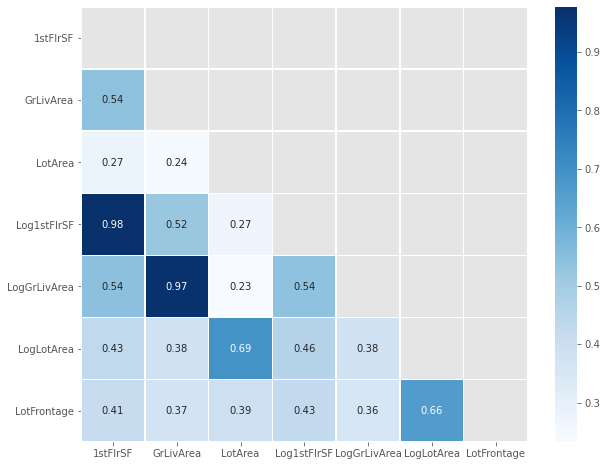

In [8]:
# 연속형 변수를 로그화
miss_data['Log1stFlrSF'] = miss_data['1stFlrSF'].apply(lambda x: np.log1p(x))
miss_data['LogGrLivArea'] = miss_data['GrLivArea'].apply(lambda x: np.log1p(x))
miss_data['LogLotArea'] = miss_data['LotArea'].apply(lambda x: np.log1p(x))

# 로그화 수행 뒤 Heatmap
corr_data = miss_data[['1stFlrSF', 'GrLivArea', 'LotArea', 'Log1stFlrSF',
                       'LogGrLivArea', 'LogLotArea', 'LotFrontage']].corr()

# 'mask' 옵션 설정
mask = np.zeros_like(corr_data, dtype = np.bool)
mask[np.triu_indices_from(mask)] = True

# 시각화 과정
plt.figure(figsize = (10, 8))

sns.heatmap(corr_data, mask = mask, cmap = 'Blues', linewidth = 0.5, annot = True, fmt = ".2f")

In [9]:
# 결측치를 없애기 위해 사용하고자 하는 변수 추출
value_list = ['Id', 'MSSubClass', 'MSZoning', 'NewLotShape', 'LotConfig', 'BldgType',
             'Log1stFlrSF', 'GrLivArea', 'LogLotArea', 'LotFrontage']

pre_miss_data = miss_data[~miss_data['LotFrontage'].isnull()][value_list]
print('Shape of pre_miss_data :', pre_miss_data.shape)

# 'MSSubClass' 변수 문자형 타입으로 변환
pre_miss_data['MSSubClass'] = pre_miss_data['MSSubClass'].astype('str')

pre_miss_data.head()

Shape of pre_miss_data : (1199, 10)


,Id,MSSubClass,MSZoning,NewLotShape,LotConfig,BldgType,Log1stFlrSF,GrLivArea,LogLotArea,LotFrontage
0,1,60,RL,Reg,Inside,1Fam,6.753438,1710,9.042040,65.0
1,2,20,RL,Reg,FR2,1Fam,7.141245,1262,9.169623,80.0
2,3,60,RL,Irreg,Inside,1Fam,6.825460,1786,9.328212,68.0
3,4,70,RL,Irreg,Corner,1Fam,6.869014,1717,9.164401,60.0
4,5,60,RL,Irreg,FR2,1Fam,7.044033,2198,9.565284,84.0


In [10]:
# RandomFroestRegressor 수행
data = pd.get_dummies(pre_miss_data, drop_first = True)

X = data.drop(['Id', 'LotFrontage'], axis = 1)
y = data['LotFrontage']

rf_model = RandomForestRegressor(random_state = 1025).fit(X, y)

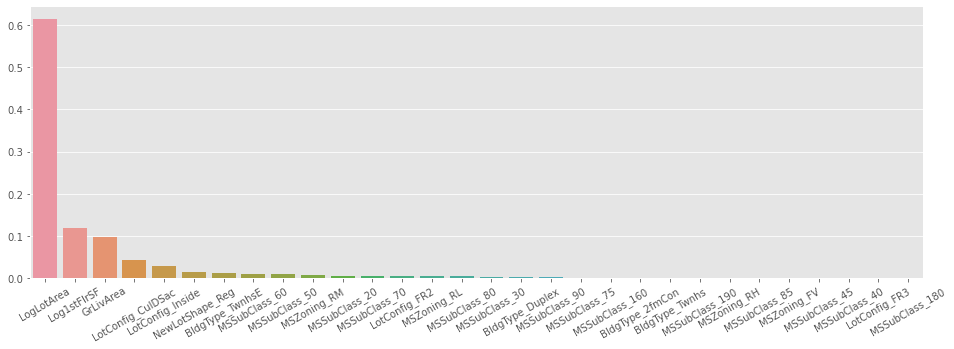

In [11]:
# 변수의 중요도 시각화
feature_data = pd.DataFrame(rf_model.feature_importances_, index = X.columns, columns = ['Importance'])

plt.figure(figsize = (16, 5))

plot_data = feature_data.sort_values(by = 'Importance', ascending = False)

sns.barplot(x = plot_data.index, y = 'Importance', data = plot_data)
plt.xticks(rotation = 30)
plt.ylabel('')
plt.show()

- LogLotArea가 가장 높은 중요도를 나타내기 때문에 LogLotArea로 결측치를 채워주자.
- 이때 채워주기 위해서 knnimputer를 사용하도록 하자.

In [12]:
# 'LotFrontage' 결측치를 대체해주는 함수 만들기
def imputer_lotfrontage(raw_data):
    
    print('Number of null values of LotFrontage *Before Modify* :', raw_data['LotFrontage'].isnull().sum(), '\n')
    
    # 'KNNImputer' 라이브러리 불러오기
    from sklearn.impute import KNNImputer
    
    # 'LotFrontage' 변수에 결측치를 가지는 'Id' 추출 후 저장
    miss_id = raw_data[raw_data['LotFrontage'].isnull()]['Id'].unique()
    
    # 'Id', 'LotFrontage', 'LotArea' 변수 추출 후 저장
    data = raw_data[['Id', 'LotFrontage', 'LotArea']]
    
    # 'LotFrontage' 변수의 값이 300 넘는 관측치를 삭제하기로 했으므로 삭제
    outlier_id = data[data['LotFrontage'] > 300]['Id']
    data = data[~data['Id'].isin(outlier_id)]
    
    # 'Id' 변수를 인덱스로 지정
    data = data.set_index('Id')
    
    # 'LotArea' 변수를 로그화 수행 후, 변수 삭제
    data['LotLogArea'] = data['LotArea'].apply(lambda x: np.log(x))
    data = data.drop('LotArea', axis = 1)
    
    # 모델 객체 생성 후 학습시키고 DataFrame으로 저장
    # 원본 데이터에 결측치로 기입되어 있는 관측치들만 수정해주기 위해 DataFrame을 만들 때, 인덱스를 위 데이터의 인덱스로 지정
    imputer = KNNImputer(n_neighbors = 5)
    pre_data = pd.DataFrame(imputer.fit_transform(data), columns = data.columns, index = data.index)
    
    # 결측치가 존재하던 관측치만 저장
    pre_data = pre_data[pre_data.index.isin(miss_id)]
    
    # 원본 데이터 결측치를 대입해주는 과정
    for id_value, lot_value in zip(pre_data.index, pre_data['LotFrontage']):
        for index in raw_data.index:
            
            if raw_data.loc[index, 'Id'] == id_value:
                raw_data.loc[index, 'LotFrontage'] = lot_value
    
    print('Number of null values of LotFrontage *After Modify* :', raw_data['LotFrontage'].isnull().sum())
 
    return raw_data

In [13]:
# 생성한 함수 적용
modify_data = imputer_lotfrontage(modify_data)

Number of null values of LotFrontage *Before Modify* : 259 

Number of null values of LotFrontage *After Modify* : 0


- knnimputer를 이용하여 모든 결측치를 처리해 주었다.

In [14]:
# 순서형 변수 중 문자열 타입으로 되어있는 변수를 변환
# 'ExterQual' & 'ExterCond'
mapping = {'Ex' : 5, 'Gd' : 4, 'TA' : 3, 'Fa' : 2, 'Po' : 1}

modify_data['ExterQual'] = modify_data['ExterQual'].map(mapping)
modify_data['ExterCond'] = modify_data['ExterCond'].map(mapping)

# 'BsmtQual' & 'BsmtCond'
mapping = {'No have' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

modify_data['BsmtQual'] = modify_data['BsmtQual'].map(mapping)
modify_data['BsmtCond'] = modify_data['BsmtCond'].map(mapping)

# 'HeatingQC'
mapping = {'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

modify_data['HeatingQC'] = modify_data['HeatingQC'].map(mapping)

# 'KitchenQual'
mapping = {'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

modify_data['KitchenQual'] = modify_data['KitchenQual'].map(mapping)

# 'FireplaceQu'
mapping = mapping = {'No have' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

modify_data['FireplaceQu'] = modify_data['FireplaceQu'].map(mapping)

# 'GarageQual' & 'GarageCond'
mapping = mapping = {'No have' : 0, 'Po' : 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

modify_data['GarageQual'] = modify_data['GarageQual'].map(mapping)
modify_data['GarageCond'] = modify_data['GarageCond'].map(mapping)

# 'PoolQC'
mapping = mapping = {'No have' : 0, 'Fa' : 1, 'TA' : 2, 'Gd' : 3, 'Ex' : 4}

modify_data['PoolQC'] = modify_data['PoolQC'].map(mapping)

In [15]:
print('Number of incorrectly entered value *Wd Shng* :',
      len(modify_data[modify_data['Exterior2nd'] == 'Wd Shng']), '\n')

print('Number of incorrectly entered value *CmentBd* :',
      len(modify_data[modify_data['Exterior2nd'] == 'CmentBd']), '\n')

print('Number of incorrectly entered value *Brk Cmn* :',
      len(modify_data[modify_data['Exterior2nd'] == 'Brk Cmn']))

Number of incorrectly entered value *Wd Shng* : 38 

Number of incorrectly entered value *CmentBd* : 60 

Number of incorrectly entered value *Brk Cmn* : 7


In [16]:
modify_data.loc[modify_data['Exterior2nd'] == 'Wd Shng', 'Exterior2nd'] = 'Wd Sdng'
modify_data.loc[modify_data['Exterior2nd'] == 'CmentBd', 'Exterior2nd'] = 'CemntBd'
modify_data.loc[modify_data['Exterior2nd'] == 'Brk Cmn', 'Exterior2nd'] = 'BrkComm'

print('Number of incorrectly entered value *Wd Shng* :',
      len(modify_data[modify_data['Exterior2nd'] == 'Wd Shng']), '\n')

print('Number of incorrectly entered value *CmentBd* :',
      len(modify_data[modify_data['Exterior2nd'] == 'CmentBd']), '\n')

print('Number of incorrectly entered value *Brk Cmn* :',
      len(modify_data[modify_data['Exterior2nd'] == 'Brk Cmn']))

Number of incorrectly entered value *Wd Shng* : 0 

Number of incorrectly entered value *CmentBd* : 0 

Number of incorrectly entered value *Brk Cmn* : 0


- 모든 결측치를 제거해 주었다.
- 이젠 변수를 살펴보며 의미있는 변수들을 만들어 주자.

In [17]:
# 결측치 제거한 데이터를 final_data로 바꿔주자.
final_data = modify_data.copy()

In [18]:
print('Shape of final_data *Before Create* :', final_data.shape, '\n')

# 'NewCondition1' 변수 생성
final_data['NewCondition1'] = np.nan

for index in final_data.index:
    
    value = final_data.loc[index, 'Condition1']
    
    if (value == 'Artery') | (value == 'Feedr'):
        final_data.loc[index, 'NewCondition1'] = 'Street'
        
    elif (value == 'PosN') | (value == 'PosA'):
        final_data.loc[index, 'NewCondition1'] = 'Positive'
        
    elif value == 'Norm':
        final_data.loc[index, 'NewCondition1'] = 'Norm'
        
    else:
        final_data.loc[index, 'NewCondition1'] = 'Rail'
        
print('Unique values of NewCondition1 :', final_data['NewCondition1'].unique(), '\n')

# 'CountCon' 변수 생성
final_data['CountCon'] = np.nan

for index in final_data.index:
    
    first_value = modify_data.loc[index, 'Condition1']
    second_value = modify_data.loc[index, 'Condition2']
    
    # 'Condition1'과 'Condition2' 변수 모두 'Norm'인 경우
    if (first_value == 'Norm') & (second_value == 'Norm'):
        final_data.loc[index, 'CountCon'] = 0
    
    else:
        final_data.loc[index, 'CountCon'] = 1

print('Unique values of CountCon :', final_data['CountCon'].unique(), '\n')
print('Shape of final_data *After Create* :', final_data.shape)

Shape of final_data *Before Create* : (1460, 81) 

Unique values of NewCondition1 : ['Norm' 'Street' 'Positive' 'Rail'] 

Unique values of CountCon : [0. 1.] 

Shape of final_data *After Create* : (1460, 83)


In [19]:
# 'SameExterior' 변수 생성
print('Shape of final_data *Before Create* :', final_data.shape, '\n')

final_data['SameExterior'] = np.nan

for index in final_data.index:
    
    first_exterior = final_data.loc[index, 'Exterior1st']
    second_exterior = final_data.loc[index, 'Exterior2nd']
    
    if first_exterior == second_exterior:
        final_data.loc[index, 'SameExterior'] = 1
    
    else:
        final_data.loc[index, 'SameExterior'] = 0
        
print('Shape of final_data *After Create* :', final_data.shape, '\n')
print('Unique vlaues of SameExterior :', final_data['SameExterior'].unique())

Shape of final_data *Before Create* : (1460, 83) 

Shape of final_data *After Create* : (1460, 84) 

Unique vlaues of SameExterior : [1. 0.]


In [20]:
# 데이터를 쉽게 사용하기 위해서 final_data를 train으로 바꿔주자.
train = final_data.copy()

In [21]:
train.MSSubClass=train.MSSubClass.astype('object')

mapping = {'No have':0,'No':1, 'Mn':2, 'Av':3, 'Gd':4}
train['BsmtExposure'] = train['BsmtExposure'].map(mapping)
mapping = {'No have':0,'LwQ':1, 'Rec':2,'BLQ':3,'ALQ':4,'Unf':5,'GLQ':6}
train['BsmtFinType1'] = train['BsmtFinType1'].map(mapping)
train['BsmtFinType2'] = train['BsmtFinType2'].map(mapping)
mapping = {'Y':1, 'N':0}
train['CentralAir'] = train['CentralAir'].map(mapping)
mapping = {'No have':0,'Unf':1, 'RFn':2, 'Fin':3}
train['GarageFinish'] = train['GarageFinish'].map(mapping)
mapping = {'N':0,'P':1,'Y':2}
train['PavedDrive'] = train['PavedDrive'].map(mapping)
mapping = {'No have':0,'MnWw':1,'GdWo':2,'MnPrv':3,'GdPrv':4}
train['Fence'] = train['Fence'].map(mapping)

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


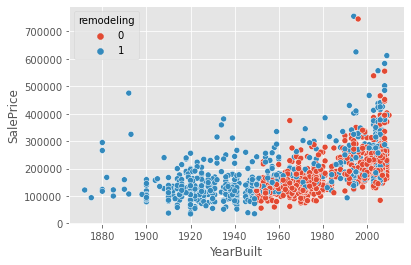

In [22]:
# YearRemodAdd와 YearBuilt를 이용하여 remodeling의 여부를 파악해보자.
train['remodeling'] = 0
for i in train.index:
    if train.loc[i,'YearBuilt'] == train.loc[i,'YearRemodAdd']:
        train.loc[i,'remodeling'] = 0
    else:
        train.loc[i,'remodeling'] = 1

# 1940년도에 지어진 건물은 거의다 remodeling을 했다.
sns.scatterplot(data = train, x = 'YearBuilt', y = 'SalePrice', hue = 'remodeling')

Text(0.5, 1.0, 'non remodeling')

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


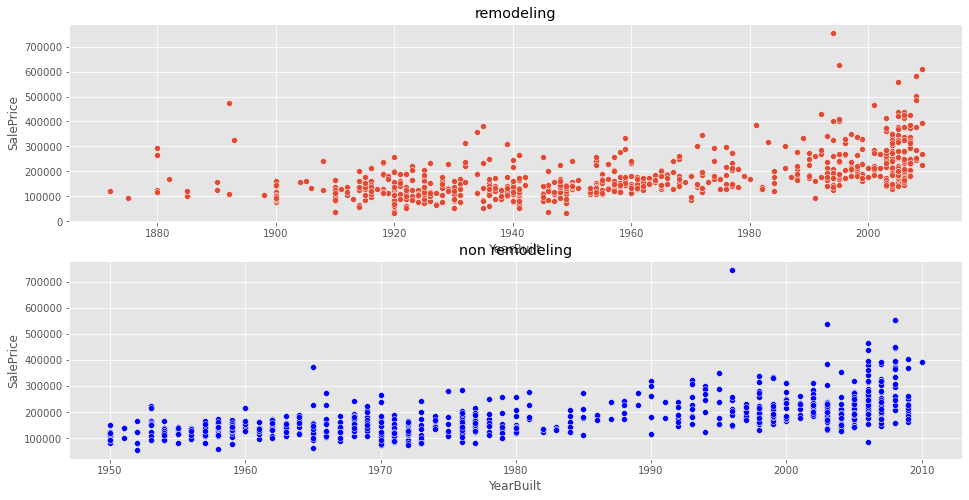

In [23]:
# 리모델링을 했는지의 여부에 따라서 YearBuilt가 달라지는지 확인해보자.
train_remodeling_1 = train[train['remodeling'] == 1]
train_remodeling_0 = train[train['remodeling'] == 0]

fig, ax = plt.subplots(nrows = 2, figsize = (16,8))
sns.scatterplot(data = train_remodeling_1, x = 'YearBuilt', y = 'SalePrice', ax = ax[0])
ax[0].set_title('remodeling')

sns.scatterplot(data = train_remodeling_0, x = 'YearBuilt', y = 'SalePrice', color = 'b',ax =ax [1])
ax[1].set_title('non remodeling')

<AxesSubplot:xlabel='remodeling', ylabel='SalePrice'>

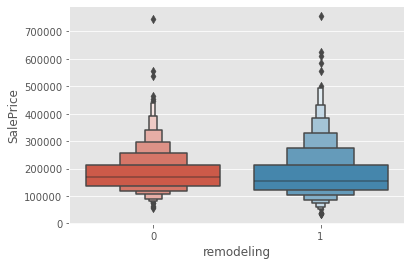

In [24]:
# boxenplot을 이용하여 리모델링 여부가 가격에 영향을 미치는지 확인해보자.
sns.boxenplot(data = train, x = 'remodeling', y = 'SalePrice')

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

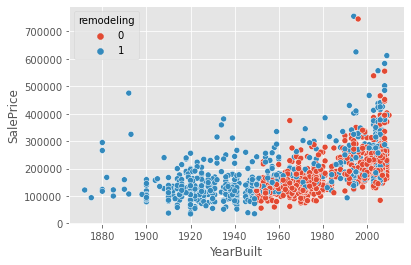

In [25]:
# 우리는 리모델링이 어떻게 데이터가 형성되어있는지 확인해보자.
sns.scatterplot(data = train, x = 'YearBuilt', y = 'SalePrice', hue = 'remodeling')

<AxesSubplot:xlabel='Year_1950', ylabel='SalePrice'>

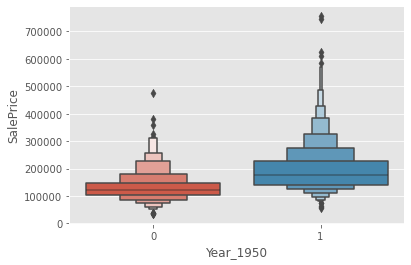

In [26]:
# 1950년 이하의 집은 리모델링을 전부 해줬기 때문에 우리는 1950년도 이상 이하를 이용하여 Year_1950이라는 변수를 만들어주도록 하자.ㅏ
train['Year_1950'] = train['YearBuilt'].apply(lambda x: 1 if x >= 1950 else 0)
sns.boxenplot(data = train, x = 'Year_1950', y = 'SalePrice')

- 확실히 1950년도 이전의 건물과 이후의 건물은 가격면에서 차이가 있다.
- 그러면 우리는 데이터를 범주화 해주도록 하자.
- 1. 1950년 이전의 건물을 0
- 2. 1950년 이후의 건물 중 리모델링을 안한 건물 1
- 3. 1950년 이후에 건물 중 리모델링을 한 건물 2

<AxesSubplot:xlabel='New_Year_feature', ylabel='SalePrice'>

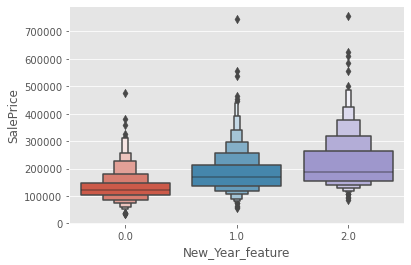

In [27]:
# 확실히 1950년도 이전의 건물과 이후의 건물이 가격면에서 차이가 있었고 remodeling의 변화를 파악하기 위해서 우리는 New_Year_feature라는 변수를 만들어 주도록 하자.
# 1. 1950년 이전의 건물을 0
# 2. 1950년 이후의 건물 중 리모델링을 안한 건물 1
# 3. 1950년 이후에 건물 중 리모델링을 한 건물 2
train['New_Year_feature'] = np.nan
for i in train.index:
    # 처음에 1950년도 이전의 건물을 뽑아내서 0을 할당한다.
    if train.loc[i,'Year_1950'] == 0:
        train.loc[i,'New_Year_feature'] = 0
    else:
    # 1950년도 이상의 건물중에서 remodeling 값이 0이면 1 1이면 2를 할당한다.
        if train.loc[i,'remodeling'] == 0:
            train.loc[i,'New_Year_feature'] = 1
        else:
            train.loc[i,'New_Year_feature'] = 2
            
sns.boxenplot(data = train, x = 'New_Year_feature', y = 'SalePrice')
# 이 변수는 각 값마다 확연한 차이가 있으므로 변수에 넣기로 했다.

BsmtBath_counts의 값 : [1. 0. 2. 3.]
Bath_counts의 값 : [3. 2. 1. 4. 0.]


Text(0.5, 1.0, 'Bath_counts vs SalePrice')

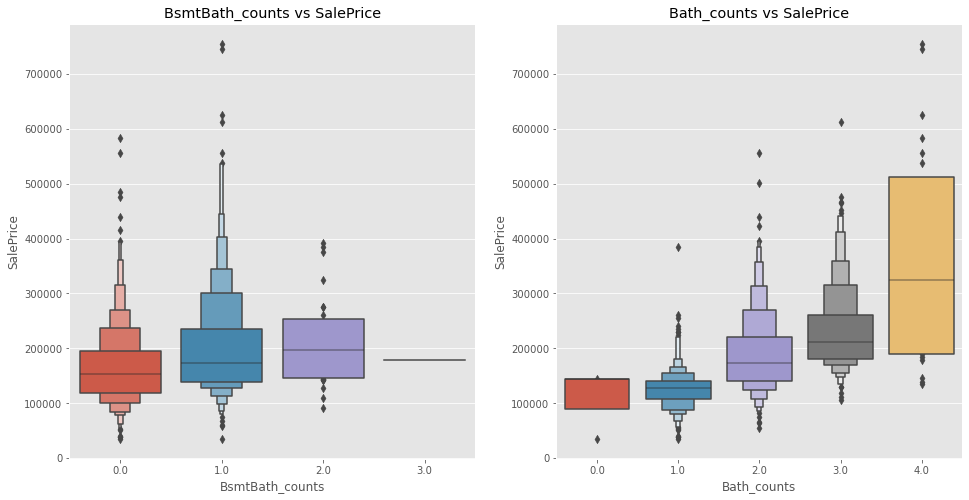

In [28]:
# 지하 화장실의 갯수를 BsmtBath_counts라는 변수로 만들어준다.
# 화장실의 갯수를 Bath_counts라는 변수로 만들어준다.
for i in train.index:
    train.loc[i,'BsmtBath_counts'] = train.loc[i,'BsmtFullBath']+train.loc[i,'BsmtHalfBath']
    train.loc[i,'Bath_counts'] = train.loc[i,'FullBath'] + train.loc[i,'HalfBath']

# 화장실의 갯수를 만든 변수들을 지워준다.
train = train.drop(['BsmtFullBath','BsmtHalfBath','FullBath','HalfBath'], axis = 1)

# 변수들을 확인한다.
print('BsmtBath_counts의 값 :',train['BsmtBath_counts'].unique())
print('Bath_counts의 값 :', train['Bath_counts'].unique())

# boxenplot으로 SalePrice와의 관계를 확인한다.
fig, ax = plt.subplots(ncols = 2, figsize = (16,8))
sns.boxenplot(data = train, x = 'BsmtBath_counts', y = 'SalePrice', ax = ax[0])
ax[0].set_title('BsmtBath_counts vs SalePrice')

sns.boxenplot(data = train, x = 'Bath_counts', y = 'SalePrice', ax = ax[1])
ax[1].set_title('Bath_counts vs SalePrice')

<AxesSubplot:xlabel='Garage_in', ylabel='SalePrice'>

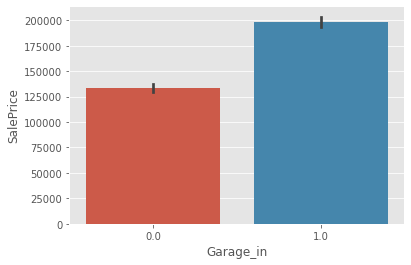

In [29]:
# CarPort와 Detchd는 집과 떨어진 주차장임으로 이것을 제외한 나머지는 Garage_in이라는 변수를 만들어주자.
train.loc[(train['GarageType'] != 'Detchd')& (train['GarageType'] != 'CarPort'),'Garage_in'] = 1
train.loc[(train['GarageType'] == 'Detchd')|(train['GarageType'] == 'CarPort'), 'Garage_in'] = 0

# 그래프를 그려보면 Garage가 집 안에 있는 경우가 더 많은 SalePrice를 갖는다.
sns.barplot(data = train, x = 'Garage_in', y = 'SalePrice')

<AxesSubplot:xlabel='Garage_exist', ylabel='SalePrice'>

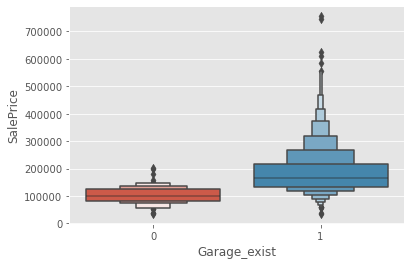

In [30]:
# Garage가 있을 때와 없을 때의 가격을 비교하기 위해 Garage_exist라는 변수를 만들어 준다.
train['Garage_exist'] = train['GarageYrBlt'].apply(lambda x:1 if x > 0 else 0)

sns.boxenplot(data = train, x = 'Garage_exist', y = 'SalePrice')

<AxesSubplot:xlabel='MasVnrArea_exist', ylabel='SalePrice'>

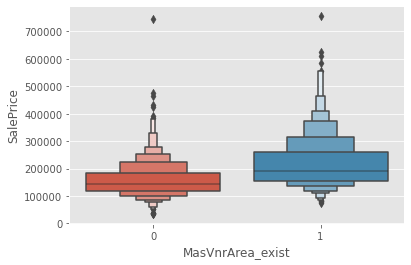

In [31]:
# MasVnrArea를 가지고 있는지 없는지로 변수를 만들어 준다.
train['MasVnrArea_exist'] = train['MasVnrArea'].apply(lambda x:1 if x > 0 else 0)
train=train.drop('MasVnrArea', axis = 1)

sns.boxenplot(data = train, x = 'MasVnrArea_exist', y = 'SalePrice')

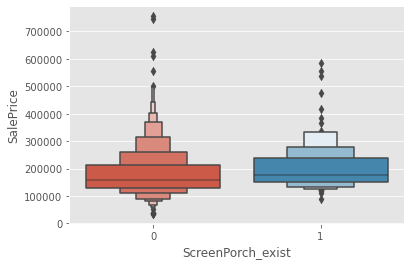

In [32]:
# ScreenPorch가 존재하는 것과 존재하지 않는 것으로 나눠준다.
train['ScreenPorch_exist'] = train['ScreenPorch'].apply(lambda x:1 if x > 0 else 0)
sns.boxenplot(data = train, x = 'ScreenPorch_exist', y = 'SalePrice')
# ScreenPorch가 1인 데이터가 더 높은 가격을 형성하는 것을 볼 수 있다.
train=train.drop('ScreenPorch', axis = 1)

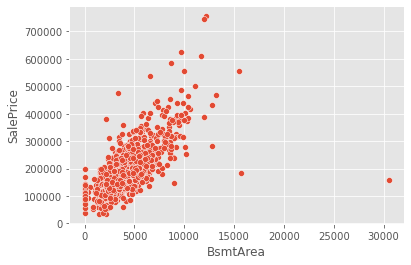

In [33]:
# 지하실의 높이와 지하 총 평방피트를 곱해서 BsmtArea라는 지하의 부피를 구해준다.
for i in train.index:
    train.loc[i,'BsmtArea'] = train.loc[i,'BsmtQual'] * train.loc[i,'TotalBsmtSF']
    
# 그래프를 그려서 관계가 있는지 확인한다.
sns.scatterplot(data = train, x = 'BsmtArea', y = 'SalePrice')

# 다중공선성이 걸리지 않게 변수를 제거해 준다.
train=train.drop(['BsmtQual','TotalBsmtSF'], axis =1)

In [34]:
# object인 column만 뽑아서 라벨 인코딩을 진행해 준다.
a = []
for i in train.columns:
    if train[i].dtype == 'object':
        a.append(i)
        
le = LabelEncoder()
for i in a:
    train[i] = le.fit_transform(train[i])

In [35]:
# 필요하지 않은 변수들이라고 생각되는 변수들을 제거해준다.
train = train.drop(['remodeling','YearRemodAdd','Year_1950','Id'], axis = 1)
train = train.drop(['Exterior1st','Exterior2nd'], axis = 1)
train = train.drop(['GarageCars','Alley'], axis = 1)
train = train.drop(['Condition1','Condition2'], axis = 1)
train = train.drop('Utilities', axis = 1)

# 이상치가 너무 많은 데이터임으로 정규화를 통해서 분석에 용이하게 만든다.
train['SalePrice'] = train['SalePrice'].apply(lambda x: np.log1p(x))

# 연속형 변수들에 로그화 해준다.
train['LotArea'] = train['LotArea'].apply(lambda x:np.log1p(x))
train['GarageArea'] = train['GarageArea'].apply(lambda x:np.log1p(x))
train['GrLivArea'] = train['GrLivArea'].apply(lambda x:np.log1p(x))
train['LotFrontage'] = train['LotFrontage'].apply(lambda x: np.log1p(x))
train['BsmtArea'] = train['BsmtArea'].apply(lambda x: np.log1p(x))

# quality데이터를 각 값에 범주화 되어있는 개수를 나눠준다. 즉, quality데이터를 가지고 하나의 변수를 만들어준다.
quality_data=['OverallQual','ExterQual','KitchenQual','FireplaceQu','GarageQual']
train['quality'] = 0
for i in quality_data:
    train['quality'] += train[i].apply(lambda x: x/len(train[i].unique()))
    train=train.drop(i,axis = 1)

           quality  SalePrice
quality    1.00000    0.82022
SalePrice  0.82022    1.00000


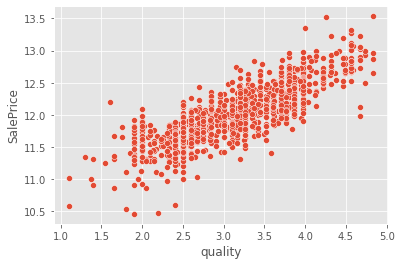

In [36]:
# quality 변수와 SalePrice의 상관관계를 확인해 본다.
sns.scatterplot(data = train, x = 'quality', y = 'SalePrice')
print(train[['quality','SalePrice']].corr())

In [37]:
# 변수가 모델에 넣을 수 있도록 int나 float으로 바뀌었는지 확인한다.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 71 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   MSSubClass         1460 non-null   int32  
 1   MSZoning           1460 non-null   int32  
 2   LotFrontage        1460 non-null   float64
 3   LotArea            1460 non-null   float64
 4   Street             1460 non-null   int32  
 5   LotShape           1460 non-null   int32  
 6   LandContour        1460 non-null   int32  
 7   LotConfig          1460 non-null   int32  
 8   LandSlope          1460 non-null   int32  
 9   Neighborhood       1460 non-null   int32  
 10  BldgType           1460 non-null   int32  
 11  HouseStyle         1460 non-null   int32  
 12  OverallCond        1460 non-null   int64  
 13  YearBuilt          1460 non-null   int64  
 14  RoofStyle          1460 non-null   int32  
 15  RoofMatl           1460 non-null   int32  
 16  MasVnrType         1460 

In [38]:
# train과 target변수로 바꾸어서 모델에 넣을 준비를 한다.
target=train.loc[:,'SalePrice']
train = train.drop('SalePrice', axis = 1)

# 데이터 중요 feature 추출

In [39]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split,KFold,cross_val_score,cross_val_predict
from sklearn.model_selection import StratifiedKFold as stk

In [40]:
# 변수를 train과 test셋으로 나누어서 LinearRegression으로 확인한다.
X_train, X_test, y_train,y_test = train_test_split(train,target, test_size = 0.2, random_state = 42)

lr=LinearRegression()
lr.fit(X_train, y_train)
y_pred=lr.predict(X_test)

RMSE=mean_squared_error(y_pred, y_test)**0.5
print('LinearRegression :', RMSE)

LinearRegression : 0.14454304257260825


In [41]:
# 중요 변수를 추출하기 위해서 statsmodels로 변수들의 P-value를 확인한다.
import statsmodels.api as sm

X = sm.add_constant(X_train)
y = y_train

model = sm.OLS(y,X)
results = model.fit()
print(results.summary())
results.pvalues

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.887
Model:                            OLS   Adj. R-squared:                  0.880
Method:                 Least Squares   F-statistic:                     123.0
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        14:00:23   Log-Likelihood:                 714.64
No. Observations:                1168   AIC:                            -1287.
Df Residuals:                    1097   BIC:                            -927.8
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.9046      6.43

const                2.831123e-01
MSSubClass           9.346001e-03
MSZoning             1.190524e-01
LotFrontage          3.609156e-01
LotArea              2.034283e-07
                         ...     
Garage_exist         6.885313e-01
MasVnrArea_exist     3.536319e-01
ScreenPorch_exist    4.489653e-03
BsmtArea             1.126627e-02
quality              1.743607e-28
Length: 71, dtype: float64

In [42]:
# p-value가 0.05이상인 변수를 제거해 준다.
data_feature=pd.DataFrame(results.pvalues)
data_feature=data_feature.rename(columns = {0:'feature'})

a = []
for index,feature in zip(data_feature.index, data_feature['feature']):
    if feature > 0.05:
        pass
    else:
        if index != 'const':
            a.append(index)

In [43]:
# 추출한 변수들을 data_feature에 저장한다.
data_feature=train[a]
data_feature.head()

,MSSubClass,LotArea,Neighborhood,OverallCond,YearBuilt,MasVnrType,Foundation,BsmtExposure,HeatingQC,2ndFlrSF,GrLivArea,KitchenAbvGr,Functional,Fireplaces,GarageArea,SaleCondition,SameExterior,BsmtBath_counts,Bath_counts,ScreenPorch_exist,BsmtArea,quality
0,5,9.042040,5,5,2003,1,2,1,5,854,7.444833,1,6,0,6.308098,4,1.0,1.0,3.0,0,8.138857,3.200000
1,0,9.169623,24,8,1976,2,1,4,5,0,7.141245,1,6,1,6.133398,4,1.0,1.0,2.0,0,8.526945,3.100000
2,5,9.328212,5,5,2001,1,2,2,5,866,7.488294,1,6,1,6.411818,4,1.0,1.0,3.0,0,8.210940,3.700000
3,6,9.164401,6,5,1915,2,0,1,4,756,7.448916,1,6,1,6.466145,0,1.0,1.0,1.0,0,7.727094,3.616667
4,5,9.565284,15,5,2000,1,2,3,5,1053,7.695758,1,6,1,6.729824,4,1.0,1.0,3.0,0,8.429673,3.800000


In [44]:
# 변수를 제거 한 이후에 다시 한번 LinearRegression으로 모델을 돌려본다.
X_train, X_test, y_train,y_test = train_test_split(data_feature,target, test_size = 0.2, random_state = 42)
lr=LinearRegression()
lr.fit(X_train, y_train)
y_pred=lr.predict(X_test)

RMSE=mean_squared_error(y_pred, y_test)**0.5
print('LinearRegression :', RMSE)

LinearRegression : 0.14883588283147914


## p-value로 추출한 변수들로 다시 한번 전처리를 진행한다.

In [45]:
# 전처리를 진행하기 위해서 변수를 데이터프레임에 넣어준다.
data_feature=pd.concat([data_feature,target], axis = 1)

Text(0.5, 1.0, 'SalePrice distribution')

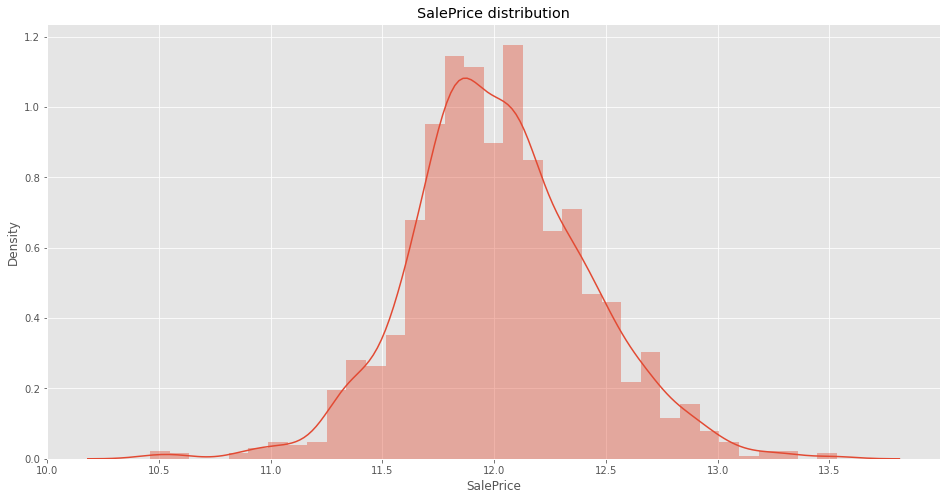

In [46]:
# SalePrice의 분포를 확인한다.
plt.figure(figsize = (16,8))
sns.distplot(data_feature['SalePrice'])
plt.title('SalePrice distribution')

In [47]:
# 결측치가 없는지 확인한다.
data_feature.isnull().sum()

MSSubClass           0
LotArea              0
Neighborhood         0
OverallCond          0
YearBuilt            0
MasVnrType           0
Foundation           0
BsmtExposure         0
HeatingQC            0
2ndFlrSF             0
GrLivArea            0
KitchenAbvGr         0
Functional           0
Fireplaces           0
GarageArea           0
SaleCondition        0
SameExterior         0
BsmtBath_counts      0
Bath_counts          0
ScreenPorch_exist    0
BsmtArea             0
quality              0
SalePrice            0
dtype: int64

## 두개의 변수로 찾아보기

In [48]:
data_feature.columns
data_feature['New_Year_feature'] = train['New_Year_feature']

<AxesSubplot:>

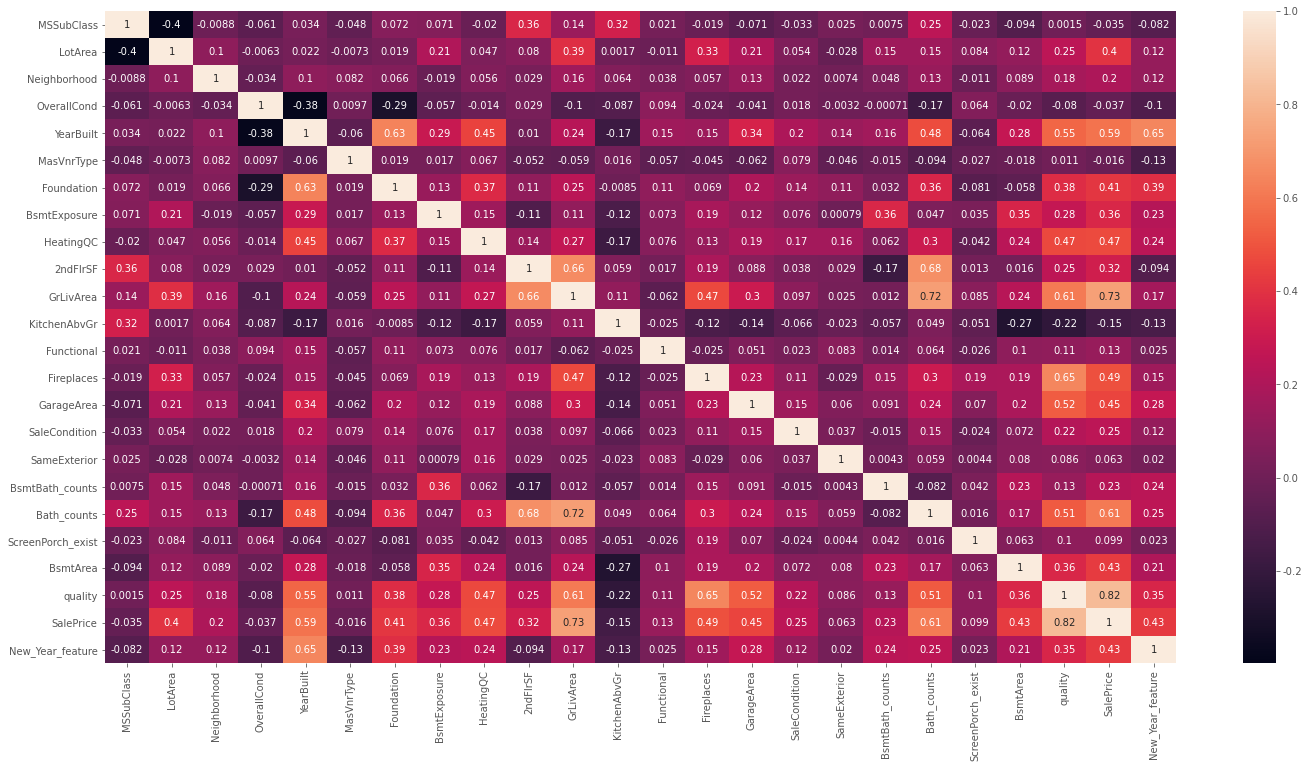

In [49]:
plt.figure(figsize = (24,12))
data_feature_corr=data_feature.corr()
sns.heatmap(data_feature_corr, annot = True)

## 다중공산성 확인해보기

In [50]:
import statsmodels.api as sm

X = sm.add_constant(data_feature.drop('SalePrice', axis = 1))
y = data_feature['SalePrice']

model = sm.OLS(y,X)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                     451.3
Date:                Mon, 17 May 2021   Prob (F-statistic):               0.00
Time:                        14:00:30   Log-Likelihood:                 807.24
No. Observations:                1460   AIC:                            -1566.
Df Residuals:                    1436   BIC:                            -1440.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.2115      0.59

In [51]:
# VIF를 이용하여 다중공선성을 확인해주려고 했지만 VIF Factor가 높은 변수들은 필요하다고 판단해서 제거하지 않기로 했다.
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif['VIF Factor'] = [variance_inflation_factor(data_feature.drop('SalePrice', axis = 1).values, i) for i in range(data_feature.drop('SalePrice',axis = 1).shape[1])]
vif['features'] = data_feature.drop('SalePrice',axis =1).columns
vif

,VIF Factor,features
0,3.889452,MSSubClass
1,578.383362,LotArea
2,5.654660,Neighborhood
3,30.698344,OverallCond
4,1496.586794,YearBuilt
5,10.065350,MasVnrType
6,8.519786,Foundation
7,4.934322,BsmtExposure
8,30.052069,HeatingQC
9,5.618422,2ndFlrSF


Text(0.5, 1.0, 'LotArea vs SalePrice')

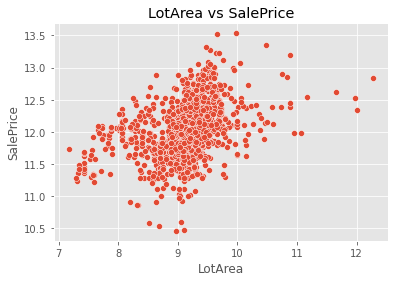

In [52]:
# LotArea와 SalePrice를 비교해본다.
sns.scatterplot(data = data_feature, x = 'LotArea', y = 'SalePrice')
plt.title('LotArea vs SalePrice')

<AxesSubplot:xlabel='MSSubClass', ylabel='SalePrice'>

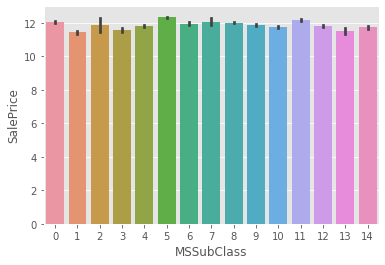

In [53]:
# MSSubClass와 SalePrice를 비교해본다.
sns.barplot(data = data_feature, x = 'MSSubClass', y = 'SalePrice')

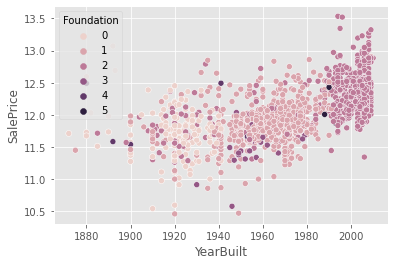

In [54]:
# YearBuilt와 SalePrice를 Foundation별로 비교해 본다.
sns.scatterplot(data = data_feature, x = 'YearBuilt', y = 'SalePrice', hue = 'Foundation')

# YearBuilt 1940년 이전 1940~1990사이 1990 이상 의 데이터들은 각 Foundation을 대표한다고 판단했고 년도별로 나눠주었다.
# YearBuilt를 Foundation을 기준으로 잘라준다.
data_feature.loc[data_feature['YearBuilt'] <= 1940,'Year_Foundation']  = 0
data_feature.loc[(data_feature['YearBuilt'] >= 1940) &(data_feature['YearBuilt'] < 1990), 'Year_Foundation'] = 1
data_feature.loc[(data_feature['YearBuilt'] >= 1990) , 'Year_Foundation'] = 2
data_feature=data_feature.drop('Foundation', axis = 1)

<AxesSubplot:xlabel='Year_Foundation', ylabel='SalePrice'>

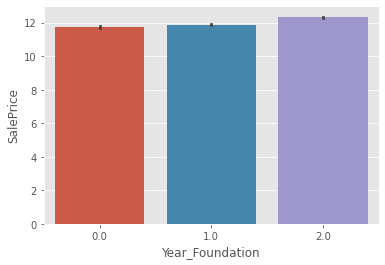

In [55]:
# Year_Foundattion과 SalePrice를 비교해준다.
sns.barplot(data = data_feature, x = 'Year_Foundation', y = 'SalePrice')

<AxesSubplot:xlabel='SaleCondition', ylabel='SalePrice'>

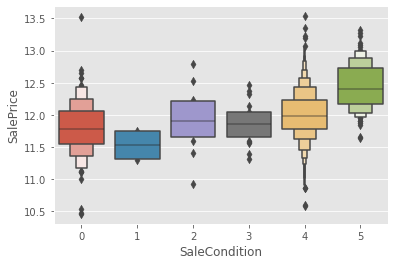

In [56]:
# SaleCondition과 SalePrice를 비교해준다.
sns.boxenplot(data = data_feature, x = 'SaleCondition', y = 'SalePrice')

# 특징을 발견하지 못해서 지워주도록 하자.

## 2ndFlrSF

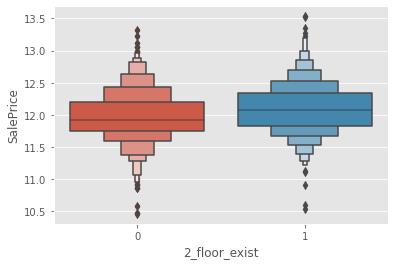

In [57]:
# 2ndFlrSF와 SalePrice를 비교해준다.
sns.scatterplot(data = data_feature, x = '2ndFlrSF',y = 'SalePrice')

# 0에 몰려있는 데이터가 많기 때문에 2층이 있으면 1 없으면 0으로 바꿔준다.
data_feature['2_floor_exist'] = data_feature['2ndFlrSF'].apply(lambda x:1 if x >0  else 0)

# 1과 0 사이에 차이가 있다.
sns.boxenplot(data = data_feature, x = '2_floor_exist', y = 'SalePrice')

# 다중공선성을 피하기 위해서 변수를 제거해 준다.
data_feature = data_feature.drop('2ndFlrSF', axis = 1)

## KitchenAbvGr

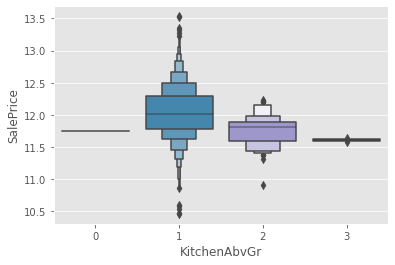

In [58]:
# KitchenAbvGr과 SalePrice를 비교해준다.
sns.boxenplot(data = data_feature, x = 'KitchenAbvGr', y = 'SalePrice')

# 특징이 있는 변수라고 판단되지 않았고 변수를 제거해 주도록 하자.
data_feature=data_feature.drop('KitchenAbvGr', axis = 1)

## HeatingQC

<AxesSubplot:xlabel='HeatingQC', ylabel='SalePrice'>

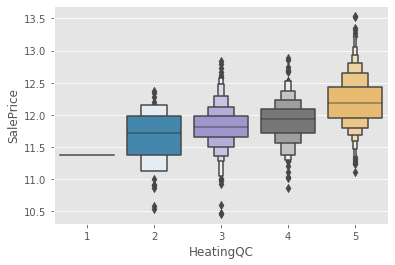

In [59]:
# HeatingQC와 SalePrice를 비교해준다.
# HeatingQC가 올라갈수록 높은 가격을 형성함으로 지워주지 않도록 한다.
sns.boxenplot(data = data_feature, x = 'HeatingQC', y = 'SalePrice')

## FirePlaces

<AxesSubplot:xlabel='Fireplaces', ylabel='SalePrice'>

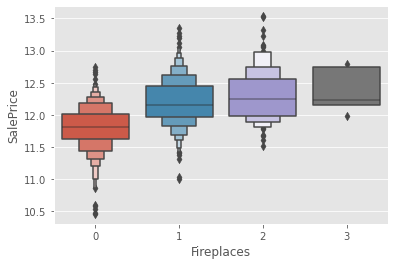

In [60]:
# FirePlaces와 SalePrice를 비교해준다.
# Fireplaces의 값이 올라갈수록 높은 SalePrice를 갖는다.
sns.boxenplot(data = data_feature, x = 'Fireplaces', y = 'SalePrice')

## Stacking ensemble을 사용한 모델링

In [61]:
from sklearn.linear_model import Ridge,Lasso,HuberRegressor,LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor

models=[LinearRegression(),Ridge(),Lasso(),RandomForestRegressor(),CatBoostRegressor()]
final_model = XGBRegressor()
def stacking_ensemble(models, data = None, target = None, test_size = 0.2,
                      n_folds = 5, final_model = final_model):
    # kfold는 StratifiedKFold를 사용한다.
    kfold = KFold(n_splits = n_folds)
    
    # 데이터를 train데이터와 test 데이터로 나누어준다.
    X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = test_size, random_state = 100)
    
    # 각 모델의 평균값을 넣어주기 위해서 공간을 만든다.
    final_train_predict = np.zeros((X_train.shape[0], len(models)))
    final_test_predict = np.zeros((X_test.shape[0], len(models)))
    
    for model_count, model in enumerate(models):
        
        # 각 모델마다 k_fold의 값들을 넣어주기 위해서 공간을 만든다.
        test_predict = np.zeros((X_test.shape[0], n_folds))
        
        # X_train의 데이터를 train과 valid로 나누기 
        for fold_count, (train_idx, valid_idx) in enumerate(kfold.split(X_train, y_train)):
            X_train_n = X_train.iloc[train_idx]
            y_train_n = y_train.iloc[train_idx]
            X_test_n = X_train.iloc[valid_idx]
        
            # 개별 모델을 학습한다.
            model = model.fit(X_train_n, y_train_n)
            final_train_predict[valid_idx, model_count] = model.predict(X_test_n)
            test_predict[:, fold_count] = model.predict(X_test)
            
        # 교차검증을 한 데이터를 가지고 평균 구하기    
        final_test_predict[:,model_count] = np.mean(test_predict, axis = 1)
                
    # 최종 모델로 학습시키기
    final_model = final_model.fit(final_train_predict, y_train)
    y_pred = final_model.predict(final_test_predict)
    
    # RMSE값 반환하기
    test_rmse = mean_squared_error(y_test, y_pred, squared = False)
    print(test_rmse)

In [62]:
stacking_ensemble(models, data = data_feature.drop('SalePrice', axis = 1),
                  target = data_feature['SalePrice'])

Learning rate set to 0.038559
0:	learn: 0.3869757	total: 158ms	remaining: 2m 37s
1:	learn: 0.3775795	total: 160ms	remaining: 1m 20s
2:	learn: 0.3682308	total: 162ms	remaining: 54s
3:	learn: 0.3587183	total: 164ms	remaining: 40.8s
4:	learn: 0.3502409	total: 166ms	remaining: 33s
5:	learn: 0.3420416	total: 168ms	remaining: 27.8s
6:	learn: 0.3339768	total: 169ms	remaining: 24s
7:	learn: 0.3267377	total: 171ms	remaining: 21.2s
8:	learn: 0.3187424	total: 173ms	remaining: 19s
9:	learn: 0.3120939	total: 175ms	remaining: 17.3s
10:	learn: 0.3055364	total: 176ms	remaining: 15.9s
11:	learn: 0.2988762	total: 178ms	remaining: 14.7s
12:	learn: 0.2925178	total: 180ms	remaining: 13.6s
13:	learn: 0.2866971	total: 182ms	remaining: 12.8s
14:	learn: 0.2813769	total: 183ms	remaining: 12s
15:	learn: 0.2757967	total: 185ms	remaining: 11.4s
16:	learn: 0.2706469	total: 187ms	remaining: 10.8s
17:	learn: 0.2654613	total: 188ms	remaining: 10.3s
18:	learn: 0.2603093	total: 190ms	remaining: 9.82s
19:	learn: 0.254936

233:	learn: 0.0866973	total: 662ms	remaining: 2.17s
234:	learn: 0.0865133	total: 665ms	remaining: 2.17s
235:	learn: 0.0863643	total: 667ms	remaining: 2.16s
236:	learn: 0.0861917	total: 668ms	remaining: 2.15s
237:	learn: 0.0860974	total: 670ms	remaining: 2.15s
238:	learn: 0.0859437	total: 672ms	remaining: 2.14s
239:	learn: 0.0858892	total: 674ms	remaining: 2.13s
240:	learn: 0.0857445	total: 677ms	remaining: 2.13s
241:	learn: 0.0857007	total: 680ms	remaining: 2.13s
242:	learn: 0.0854624	total: 682ms	remaining: 2.12s
243:	learn: 0.0854081	total: 683ms	remaining: 2.12s
244:	learn: 0.0851997	total: 685ms	remaining: 2.11s
245:	learn: 0.0850203	total: 686ms	remaining: 2.1s
246:	learn: 0.0848075	total: 688ms	remaining: 2.1s
247:	learn: 0.0846376	total: 691ms	remaining: 2.09s
248:	learn: 0.0845104	total: 693ms	remaining: 2.09s
249:	learn: 0.0844000	total: 695ms	remaining: 2.08s
250:	learn: 0.0843601	total: 696ms	remaining: 2.08s
251:	learn: 0.0842114	total: 698ms	remaining: 2.07s
252:	learn: 0.

393:	learn: 0.0666486	total: 987ms	remaining: 1.52s
394:	learn: 0.0665219	total: 989ms	remaining: 1.51s
395:	learn: 0.0664038	total: 991ms	remaining: 1.51s
396:	learn: 0.0662672	total: 993ms	remaining: 1.51s
397:	learn: 0.0662395	total: 995ms	remaining: 1.5s
398:	learn: 0.0661524	total: 997ms	remaining: 1.5s
399:	learn: 0.0660475	total: 998ms	remaining: 1.5s
400:	learn: 0.0659464	total: 1000ms	remaining: 1.49s
401:	learn: 0.0658697	total: 1s	remaining: 1.49s
402:	learn: 0.0657868	total: 1s	remaining: 1.49s
403:	learn: 0.0657125	total: 1s	remaining: 1.48s
404:	learn: 0.0656225	total: 1.01s	remaining: 1.48s
405:	learn: 0.0654577	total: 1.01s	remaining: 1.48s
406:	learn: 0.0653281	total: 1.01s	remaining: 1.48s
407:	learn: 0.0652098	total: 1.01s	remaining: 1.47s
408:	learn: 0.0651403	total: 1.02s	remaining: 1.47s
409:	learn: 0.0650184	total: 1.02s	remaining: 1.47s
410:	learn: 0.0648566	total: 1.02s	remaining: 1.46s
411:	learn: 0.0647531	total: 1.02s	remaining: 1.46s
412:	learn: 0.0646515	t

630:	learn: 0.0494814	total: 1.48s	remaining: 867ms
631:	learn: 0.0494146	total: 1.48s	remaining: 864ms
632:	learn: 0.0493603	total: 1.49s	remaining: 862ms
633:	learn: 0.0492408	total: 1.49s	remaining: 859ms
634:	learn: 0.0492166	total: 1.49s	remaining: 856ms
635:	learn: 0.0491371	total: 1.49s	remaining: 854ms
636:	learn: 0.0490896	total: 1.49s	remaining: 851ms
637:	learn: 0.0490871	total: 1.5s	remaining: 849ms
638:	learn: 0.0490414	total: 1.5s	remaining: 846ms
639:	learn: 0.0489656	total: 1.5s	remaining: 843ms
640:	learn: 0.0489152	total: 1.5s	remaining: 840ms
641:	learn: 0.0488618	total: 1.5s	remaining: 838ms
642:	learn: 0.0487995	total: 1.5s	remaining: 835ms
643:	learn: 0.0487295	total: 1.5s	remaining: 832ms
644:	learn: 0.0486303	total: 1.51s	remaining: 829ms
645:	learn: 0.0485747	total: 1.51s	remaining: 827ms
646:	learn: 0.0485016	total: 1.51s	remaining: 824ms
647:	learn: 0.0484872	total: 1.51s	remaining: 821ms
648:	learn: 0.0484140	total: 1.51s	remaining: 819ms
649:	learn: 0.04833

792:	learn: 0.0418652	total: 1.82s	remaining: 474ms
793:	learn: 0.0417879	total: 1.82s	remaining: 472ms
794:	learn: 0.0417715	total: 1.82s	remaining: 469ms
795:	learn: 0.0417037	total: 1.82s	remaining: 467ms
796:	learn: 0.0416720	total: 1.82s	remaining: 465ms
797:	learn: 0.0416335	total: 1.83s	remaining: 462ms
798:	learn: 0.0415678	total: 1.83s	remaining: 460ms
799:	learn: 0.0415487	total: 1.83s	remaining: 457ms
800:	learn: 0.0414990	total: 1.83s	remaining: 455ms
801:	learn: 0.0414550	total: 1.83s	remaining: 453ms
802:	learn: 0.0414009	total: 1.83s	remaining: 450ms
803:	learn: 0.0413589	total: 1.84s	remaining: 448ms
804:	learn: 0.0413198	total: 1.84s	remaining: 446ms
805:	learn: 0.0412908	total: 1.84s	remaining: 444ms
806:	learn: 0.0412254	total: 1.84s	remaining: 441ms
807:	learn: 0.0411589	total: 1.85s	remaining: 439ms
808:	learn: 0.0411300	total: 1.85s	remaining: 436ms
809:	learn: 0.0410933	total: 1.85s	remaining: 434ms
810:	learn: 0.0410640	total: 1.85s	remaining: 432ms
811:	learn: 

4:	learn: 0.3505537	total: 12ms	remaining: 2.38s
5:	learn: 0.3427209	total: 14.3ms	remaining: 2.36s
6:	learn: 0.3345878	total: 16.3ms	remaining: 2.31s
7:	learn: 0.3273210	total: 18.2ms	remaining: 2.25s
8:	learn: 0.3201806	total: 20.2ms	remaining: 2.22s
9:	learn: 0.3135143	total: 22.6ms	remaining: 2.24s
10:	learn: 0.3067843	total: 24.2ms	remaining: 2.18s
11:	learn: 0.2997895	total: 26.6ms	remaining: 2.19s
12:	learn: 0.2940506	total: 28.4ms	remaining: 2.16s
13:	learn: 0.2881996	total: 30ms	remaining: 2.11s
14:	learn: 0.2826203	total: 31.6ms	remaining: 2.08s
15:	learn: 0.2769701	total: 33.3ms	remaining: 2.04s
16:	learn: 0.2716425	total: 35.9ms	remaining: 2.08s
17:	learn: 0.2665008	total: 38.1ms	remaining: 2.08s
18:	learn: 0.2614255	total: 40ms	remaining: 2.06s
19:	learn: 0.2563504	total: 41.8ms	remaining: 2.05s
20:	learn: 0.2516420	total: 44.6ms	remaining: 2.08s
21:	learn: 0.2468642	total: 46.2ms	remaining: 2.06s
22:	learn: 0.2427580	total: 48ms	remaining: 2.04s
23:	learn: 0.2386431	total

241:	learn: 0.0897764	total: 511ms	remaining: 1.6s
242:	learn: 0.0897002	total: 514ms	remaining: 1.6s
243:	learn: 0.0896780	total: 516ms	remaining: 1.6s
244:	learn: 0.0896056	total: 518ms	remaining: 1.6s
245:	learn: 0.0895328	total: 520ms	remaining: 1.59s
246:	learn: 0.0894308	total: 523ms	remaining: 1.59s
247:	learn: 0.0892889	total: 525ms	remaining: 1.59s
248:	learn: 0.0892004	total: 527ms	remaining: 1.59s
249:	learn: 0.0890242	total: 529ms	remaining: 1.59s
250:	learn: 0.0888616	total: 530ms	remaining: 1.58s
251:	learn: 0.0886714	total: 532ms	remaining: 1.58s
252:	learn: 0.0885876	total: 534ms	remaining: 1.57s
253:	learn: 0.0884710	total: 535ms	remaining: 1.57s
254:	learn: 0.0883585	total: 538ms	remaining: 1.57s
255:	learn: 0.0882088	total: 540ms	remaining: 1.57s
256:	learn: 0.0881309	total: 544ms	remaining: 1.57s
257:	learn: 0.0880725	total: 547ms	remaining: 1.57s
258:	learn: 0.0879197	total: 548ms	remaining: 1.57s
259:	learn: 0.0878574	total: 551ms	remaining: 1.57s
260:	learn: 0.08

457:	learn: 0.0643420	total: 1s	remaining: 1.19s
458:	learn: 0.0641861	total: 1.01s	remaining: 1.19s
459:	learn: 0.0640478	total: 1.01s	remaining: 1.19s
460:	learn: 0.0639764	total: 1.01s	remaining: 1.18s
461:	learn: 0.0638927	total: 1.01s	remaining: 1.18s
462:	learn: 0.0638263	total: 1.02s	remaining: 1.18s
463:	learn: 0.0637290	total: 1.02s	remaining: 1.18s
464:	learn: 0.0636498	total: 1.02s	remaining: 1.17s
465:	learn: 0.0635709	total: 1.02s	remaining: 1.17s
466:	learn: 0.0634817	total: 1.02s	remaining: 1.17s
467:	learn: 0.0633578	total: 1.03s	remaining: 1.17s
468:	learn: 0.0632356	total: 1.03s	remaining: 1.16s
469:	learn: 0.0631330	total: 1.03s	remaining: 1.16s
470:	learn: 0.0630452	total: 1.03s	remaining: 1.16s
471:	learn: 0.0629744	total: 1.03s	remaining: 1.16s
472:	learn: 0.0629210	total: 1.03s	remaining: 1.15s
473:	learn: 0.0628023	total: 1.04s	remaining: 1.15s
474:	learn: 0.0626932	total: 1.04s	remaining: 1.15s
475:	learn: 0.0625963	total: 1.04s	remaining: 1.15s
476:	learn: 0.0

692:	learn: 0.0488431	total: 1.5s	remaining: 664ms
693:	learn: 0.0487882	total: 1.5s	remaining: 662ms
694:	learn: 0.0487559	total: 1.5s	remaining: 660ms
695:	learn: 0.0487209	total: 1.51s	remaining: 659ms
696:	learn: 0.0486639	total: 1.51s	remaining: 656ms
697:	learn: 0.0486223	total: 1.51s	remaining: 654ms
698:	learn: 0.0485526	total: 1.51s	remaining: 652ms
699:	learn: 0.0485508	total: 1.51s	remaining: 649ms
700:	learn: 0.0485386	total: 1.52s	remaining: 647ms
701:	learn: 0.0484961	total: 1.52s	remaining: 644ms
702:	learn: 0.0484377	total: 1.52s	remaining: 642ms
703:	learn: 0.0483971	total: 1.52s	remaining: 641ms
704:	learn: 0.0483279	total: 1.53s	remaining: 639ms
705:	learn: 0.0482628	total: 1.53s	remaining: 637ms
706:	learn: 0.0482270	total: 1.53s	remaining: 634ms
707:	learn: 0.0481724	total: 1.53s	remaining: 632ms
708:	learn: 0.0481172	total: 1.54s	remaining: 631ms
709:	learn: 0.0480601	total: 1.54s	remaining: 628ms
710:	learn: 0.0480449	total: 1.54s	remaining: 626ms
711:	learn: 0.0

855:	learn: 0.0418373	total: 1.83s	remaining: 308ms
856:	learn: 0.0417858	total: 1.83s	remaining: 306ms
857:	learn: 0.0417724	total: 1.83s	remaining: 304ms
858:	learn: 0.0416992	total: 1.84s	remaining: 302ms
859:	learn: 0.0416728	total: 1.84s	remaining: 299ms
860:	learn: 0.0416392	total: 1.84s	remaining: 297ms
861:	learn: 0.0416363	total: 1.84s	remaining: 295ms
862:	learn: 0.0416243	total: 1.84s	remaining: 293ms
863:	learn: 0.0415804	total: 1.85s	remaining: 291ms
864:	learn: 0.0415384	total: 1.85s	remaining: 289ms
865:	learn: 0.0414679	total: 1.85s	remaining: 287ms
866:	learn: 0.0414390	total: 1.85s	remaining: 285ms
867:	learn: 0.0414236	total: 1.86s	remaining: 282ms
868:	learn: 0.0413713	total: 1.86s	remaining: 280ms
869:	learn: 0.0413400	total: 1.86s	remaining: 278ms
870:	learn: 0.0412865	total: 1.86s	remaining: 276ms
871:	learn: 0.0412408	total: 1.86s	remaining: 274ms
872:	learn: 0.0412079	total: 1.87s	remaining: 272ms
873:	learn: 0.0412052	total: 1.87s	remaining: 269ms
874:	learn: 

78:	learn: 0.1336647	total: 172ms	remaining: 2s
79:	learn: 0.1330250	total: 174ms	remaining: 2s
80:	learn: 0.1322073	total: 175ms	remaining: 1.99s
81:	learn: 0.1316440	total: 178ms	remaining: 1.99s
82:	learn: 0.1309410	total: 180ms	remaining: 1.99s
83:	learn: 0.1304041	total: 182ms	remaining: 1.98s
84:	learn: 0.1297668	total: 184ms	remaining: 1.98s
85:	learn: 0.1292268	total: 185ms	remaining: 1.97s
86:	learn: 0.1286788	total: 187ms	remaining: 1.96s
87:	learn: 0.1281047	total: 188ms	remaining: 1.95s
88:	learn: 0.1275244	total: 191ms	remaining: 1.96s
89:	learn: 0.1268846	total: 196ms	remaining: 1.98s
90:	learn: 0.1263311	total: 199ms	remaining: 1.99s
91:	learn: 0.1258393	total: 201ms	remaining: 1.98s
92:	learn: 0.1253226	total: 203ms	remaining: 1.98s
93:	learn: 0.1246804	total: 204ms	remaining: 1.97s
94:	learn: 0.1241081	total: 206ms	remaining: 1.97s
95:	learn: 0.1236084	total: 210ms	remaining: 1.97s
96:	learn: 0.1231604	total: 212ms	remaining: 1.97s
97:	learn: 0.1227890	total: 213ms	rem

237:	learn: 0.0905899	total: 507ms	remaining: 1.62s
238:	learn: 0.0905087	total: 509ms	remaining: 1.62s
239:	learn: 0.0903849	total: 511ms	remaining: 1.62s
240:	learn: 0.0901602	total: 513ms	remaining: 1.61s
241:	learn: 0.0900285	total: 515ms	remaining: 1.61s
242:	learn: 0.0899471	total: 517ms	remaining: 1.61s
243:	learn: 0.0897846	total: 519ms	remaining: 1.61s
244:	learn: 0.0896321	total: 524ms	remaining: 1.61s
245:	learn: 0.0895391	total: 527ms	remaining: 1.62s
246:	learn: 0.0893411	total: 529ms	remaining: 1.61s
247:	learn: 0.0891663	total: 531ms	remaining: 1.61s
248:	learn: 0.0890865	total: 533ms	remaining: 1.61s
249:	learn: 0.0889605	total: 535ms	remaining: 1.61s
250:	learn: 0.0888629	total: 537ms	remaining: 1.6s
251:	learn: 0.0888233	total: 539ms	remaining: 1.6s
252:	learn: 0.0887178	total: 540ms	remaining: 1.59s
253:	learn: 0.0885760	total: 542ms	remaining: 1.59s
254:	learn: 0.0883512	total: 544ms	remaining: 1.59s
255:	learn: 0.0882775	total: 546ms	remaining: 1.59s
256:	learn: 0.

396:	learn: 0.0715256	total: 857ms	remaining: 1.3s
397:	learn: 0.0714460	total: 859ms	remaining: 1.3s
398:	learn: 0.0713727	total: 861ms	remaining: 1.3s
399:	learn: 0.0712647	total: 863ms	remaining: 1.29s
400:	learn: 0.0711714	total: 867ms	remaining: 1.29s
401:	learn: 0.0710612	total: 868ms	remaining: 1.29s
402:	learn: 0.0709898	total: 870ms	remaining: 1.29s
403:	learn: 0.0709253	total: 873ms	remaining: 1.29s
404:	learn: 0.0708444	total: 875ms	remaining: 1.28s
405:	learn: 0.0707750	total: 877ms	remaining: 1.28s
406:	learn: 0.0706954	total: 880ms	remaining: 1.28s
407:	learn: 0.0705128	total: 882ms	remaining: 1.28s
408:	learn: 0.0704448	total: 884ms	remaining: 1.28s
409:	learn: 0.0703768	total: 886ms	remaining: 1.27s
410:	learn: 0.0702342	total: 887ms	remaining: 1.27s
411:	learn: 0.0701554	total: 889ms	remaining: 1.27s
412:	learn: 0.0700365	total: 891ms	remaining: 1.27s
413:	learn: 0.0698918	total: 893ms	remaining: 1.26s
414:	learn: 0.0697669	total: 895ms	remaining: 1.26s
415:	learn: 0.0

633:	learn: 0.0539673	total: 1.36s	remaining: 784ms
634:	learn: 0.0539462	total: 1.36s	remaining: 781ms
635:	learn: 0.0539156	total: 1.36s	remaining: 779ms
636:	learn: 0.0538429	total: 1.36s	remaining: 777ms
637:	learn: 0.0537846	total: 1.36s	remaining: 775ms
638:	learn: 0.0537711	total: 1.37s	remaining: 772ms
639:	learn: 0.0536584	total: 1.37s	remaining: 770ms
640:	learn: 0.0535924	total: 1.37s	remaining: 768ms
641:	learn: 0.0535281	total: 1.37s	remaining: 765ms
642:	learn: 0.0534591	total: 1.37s	remaining: 763ms
643:	learn: 0.0534533	total: 1.38s	remaining: 761ms
644:	learn: 0.0533984	total: 1.38s	remaining: 759ms
645:	learn: 0.0533743	total: 1.39s	remaining: 763ms
646:	learn: 0.0533629	total: 1.39s	remaining: 761ms
647:	learn: 0.0533120	total: 1.4s	remaining: 759ms
648:	learn: 0.0532749	total: 1.4s	remaining: 757ms
649:	learn: 0.0532037	total: 1.4s	remaining: 754ms
650:	learn: 0.0531280	total: 1.4s	remaining: 752ms
651:	learn: 0.0530549	total: 1.4s	remaining: 749ms
652:	learn: 0.053

871:	learn: 0.0427402	total: 1.86s	remaining: 273ms
872:	learn: 0.0427051	total: 1.86s	remaining: 270ms
873:	learn: 0.0426553	total: 1.86s	remaining: 268ms
874:	learn: 0.0426041	total: 1.86s	remaining: 266ms
875:	learn: 0.0425684	total: 1.86s	remaining: 264ms
876:	learn: 0.0425219	total: 1.87s	remaining: 262ms
877:	learn: 0.0424605	total: 1.87s	remaining: 260ms
878:	learn: 0.0424098	total: 1.87s	remaining: 258ms
879:	learn: 0.0423821	total: 1.88s	remaining: 256ms
880:	learn: 0.0423508	total: 1.88s	remaining: 254ms
881:	learn: 0.0423184	total: 1.88s	remaining: 252ms
882:	learn: 0.0422834	total: 1.88s	remaining: 249ms
883:	learn: 0.0422447	total: 1.89s	remaining: 247ms
884:	learn: 0.0422086	total: 1.89s	remaining: 245ms
885:	learn: 0.0421751	total: 1.89s	remaining: 243ms
886:	learn: 0.0421303	total: 1.89s	remaining: 241ms
887:	learn: 0.0420556	total: 1.9s	remaining: 239ms
888:	learn: 0.0420109	total: 1.9s	remaining: 237ms
889:	learn: 0.0419479	total: 1.9s	remaining: 235ms
890:	learn: 0.0

68:	learn: 0.1445468	total: 191ms	remaining: 2.58s
69:	learn: 0.1437225	total: 196ms	remaining: 2.6s
70:	learn: 0.1428448	total: 197ms	remaining: 2.58s
71:	learn: 0.1420401	total: 199ms	remaining: 2.56s
72:	learn: 0.1410857	total: 201ms	remaining: 2.55s
73:	learn: 0.1401987	total: 202ms	remaining: 2.53s
74:	learn: 0.1392733	total: 205ms	remaining: 2.53s
75:	learn: 0.1385973	total: 209ms	remaining: 2.54s
76:	learn: 0.1378163	total: 211ms	remaining: 2.53s
77:	learn: 0.1369625	total: 212ms	remaining: 2.51s
78:	learn: 0.1363370	total: 214ms	remaining: 2.5s
79:	learn: 0.1355577	total: 216ms	remaining: 2.48s
80:	learn: 0.1349886	total: 217ms	remaining: 2.47s
81:	learn: 0.1343112	total: 219ms	remaining: 2.45s
82:	learn: 0.1336095	total: 221ms	remaining: 2.44s
83:	learn: 0.1329673	total: 223ms	remaining: 2.43s
84:	learn: 0.1324024	total: 224ms	remaining: 2.41s
85:	learn: 0.1318743	total: 226ms	remaining: 2.4s
86:	learn: 0.1311178	total: 227ms	remaining: 2.39s
87:	learn: 0.1305971	total: 230ms	

228:	learn: 0.0954795	total: 522ms	remaining: 1.76s
229:	learn: 0.0951709	total: 525ms	remaining: 1.76s
230:	learn: 0.0949886	total: 527ms	remaining: 1.75s
231:	learn: 0.0949551	total: 529ms	remaining: 1.75s
232:	learn: 0.0948404	total: 531ms	remaining: 1.75s
233:	learn: 0.0947829	total: 532ms	remaining: 1.74s
234:	learn: 0.0945321	total: 534ms	remaining: 1.74s
235:	learn: 0.0945014	total: 537ms	remaining: 1.74s
236:	learn: 0.0943976	total: 538ms	remaining: 1.73s
237:	learn: 0.0943679	total: 541ms	remaining: 1.73s
238:	learn: 0.0941162	total: 546ms	remaining: 1.74s
239:	learn: 0.0940774	total: 548ms	remaining: 1.74s
240:	learn: 0.0939492	total: 553ms	remaining: 1.74s
241:	learn: 0.0937507	total: 555ms	remaining: 1.74s
242:	learn: 0.0937200	total: 557ms	remaining: 1.74s
243:	learn: 0.0934822	total: 559ms	remaining: 1.73s
244:	learn: 0.0933063	total: 560ms	remaining: 1.73s
245:	learn: 0.0932643	total: 562ms	remaining: 1.72s
246:	learn: 0.0931359	total: 564ms	remaining: 1.72s
247:	learn: 

459:	learn: 0.0688731	total: 1.02s	remaining: 1.2s
460:	learn: 0.0687506	total: 1.03s	remaining: 1.2s
461:	learn: 0.0686504	total: 1.03s	remaining: 1.2s
462:	learn: 0.0685247	total: 1.03s	remaining: 1.19s
463:	learn: 0.0684543	total: 1.03s	remaining: 1.19s
464:	learn: 0.0684477	total: 1.03s	remaining: 1.19s
465:	learn: 0.0684422	total: 1.03s	remaining: 1.19s
466:	learn: 0.0683055	total: 1.04s	remaining: 1.18s
467:	learn: 0.0682992	total: 1.04s	remaining: 1.18s
468:	learn: 0.0682059	total: 1.04s	remaining: 1.18s
469:	learn: 0.0681545	total: 1.04s	remaining: 1.18s
470:	learn: 0.0681456	total: 1.04s	remaining: 1.17s
471:	learn: 0.0679835	total: 1.05s	remaining: 1.17s
472:	learn: 0.0679081	total: 1.05s	remaining: 1.17s
473:	learn: 0.0677839	total: 1.05s	remaining: 1.16s
474:	learn: 0.0677236	total: 1.05s	remaining: 1.16s
475:	learn: 0.0677019	total: 1.05s	remaining: 1.16s
476:	learn: 0.0676165	total: 1.05s	remaining: 1.16s
477:	learn: 0.0675505	total: 1.06s	remaining: 1.15s
478:	learn: 0.0

620:	learn: 0.0569409	total: 1.36s	remaining: 828ms
621:	learn: 0.0568925	total: 1.36s	remaining: 826ms
622:	learn: 0.0568473	total: 1.36s	remaining: 823ms
623:	learn: 0.0567819	total: 1.36s	remaining: 821ms
624:	learn: 0.0567175	total: 1.36s	remaining: 819ms
625:	learn: 0.0566646	total: 1.37s	remaining: 817ms
626:	learn: 0.0565504	total: 1.37s	remaining: 815ms
627:	learn: 0.0564888	total: 1.37s	remaining: 812ms
628:	learn: 0.0564849	total: 1.37s	remaining: 810ms
629:	learn: 0.0564342	total: 1.37s	remaining: 807ms
630:	learn: 0.0563249	total: 1.38s	remaining: 805ms
631:	learn: 0.0562528	total: 1.38s	remaining: 802ms
632:	learn: 0.0561817	total: 1.38s	remaining: 801ms
633:	learn: 0.0561333	total: 1.38s	remaining: 799ms
634:	learn: 0.0560614	total: 1.39s	remaining: 797ms
635:	learn: 0.0559902	total: 1.39s	remaining: 795ms
636:	learn: 0.0559851	total: 1.39s	remaining: 793ms
637:	learn: 0.0559510	total: 1.39s	remaining: 790ms
638:	learn: 0.0558987	total: 1.39s	remaining: 788ms
639:	learn: 

779:	learn: 0.0477387	total: 1.69s	remaining: 477ms
780:	learn: 0.0476861	total: 1.69s	remaining: 475ms
781:	learn: 0.0476497	total: 1.7s	remaining: 473ms
782:	learn: 0.0476161	total: 1.7s	remaining: 470ms
783:	learn: 0.0475753	total: 1.7s	remaining: 468ms
784:	learn: 0.0475010	total: 1.7s	remaining: 466ms
785:	learn: 0.0474752	total: 1.7s	remaining: 464ms
786:	learn: 0.0474097	total: 1.71s	remaining: 462ms
787:	learn: 0.0473479	total: 1.71s	remaining: 460ms
788:	learn: 0.0472917	total: 1.71s	remaining: 458ms
789:	learn: 0.0472432	total: 1.71s	remaining: 455ms
790:	learn: 0.0472314	total: 1.71s	remaining: 453ms
791:	learn: 0.0471810	total: 1.72s	remaining: 451ms
792:	learn: 0.0471424	total: 1.72s	remaining: 448ms
793:	learn: 0.0470863	total: 1.72s	remaining: 446ms
794:	learn: 0.0470651	total: 1.72s	remaining: 444ms
795:	learn: 0.0470601	total: 1.72s	remaining: 442ms
796:	learn: 0.0470220	total: 1.73s	remaining: 440ms
797:	learn: 0.0469679	total: 1.73s	remaining: 438ms
798:	learn: 0.046

941:	learn: 0.0409003	total: 2.02s	remaining: 124ms
942:	learn: 0.0408587	total: 2.02s	remaining: 122ms
943:	learn: 0.0407984	total: 2.02s	remaining: 120ms
944:	learn: 0.0407653	total: 2.02s	remaining: 118ms
945:	learn: 0.0407329	total: 2.03s	remaining: 116ms
946:	learn: 0.0407024	total: 2.03s	remaining: 114ms
947:	learn: 0.0406738	total: 2.03s	remaining: 111ms
948:	learn: 0.0406125	total: 2.03s	remaining: 109ms
949:	learn: 0.0405802	total: 2.03s	remaining: 107ms
950:	learn: 0.0405519	total: 2.04s	remaining: 105ms
951:	learn: 0.0405374	total: 2.04s	remaining: 103ms
952:	learn: 0.0405133	total: 2.04s	remaining: 101ms
953:	learn: 0.0404726	total: 2.04s	remaining: 98.5ms
954:	learn: 0.0404348	total: 2.05s	remaining: 96.4ms
955:	learn: 0.0403726	total: 2.05s	remaining: 94.4ms
956:	learn: 0.0403375	total: 2.05s	remaining: 92.2ms
957:	learn: 0.0403080	total: 2.05s	remaining: 90ms
958:	learn: 0.0402808	total: 2.06s	remaining: 87.9ms
959:	learn: 0.0402129	total: 2.06s	remaining: 85.7ms
960:	le

149:	learn: 0.1065101	total: 340ms	remaining: 1.93s
150:	learn: 0.1063453	total: 342ms	remaining: 1.92s
151:	learn: 0.1060681	total: 344ms	remaining: 1.92s
152:	learn: 0.1059195	total: 346ms	remaining: 1.91s
153:	learn: 0.1057399	total: 348ms	remaining: 1.91s
154:	learn: 0.1055789	total: 350ms	remaining: 1.91s
155:	learn: 0.1053478	total: 351ms	remaining: 1.9s
156:	learn: 0.1051248	total: 353ms	remaining: 1.9s
157:	learn: 0.1048036	total: 356ms	remaining: 1.9s
158:	learn: 0.1045782	total: 358ms	remaining: 1.89s
159:	learn: 0.1044411	total: 363ms	remaining: 1.9s
160:	learn: 0.1042125	total: 365ms	remaining: 1.9s
161:	learn: 0.1040271	total: 369ms	remaining: 1.91s
162:	learn: 0.1037807	total: 370ms	remaining: 1.9s
163:	learn: 0.1036388	total: 372ms	remaining: 1.9s
164:	learn: 0.1035540	total: 375ms	remaining: 1.9s
165:	learn: 0.1033483	total: 377ms	remaining: 1.89s
166:	learn: 0.1031692	total: 378ms	remaining: 1.89s
167:	learn: 0.1029472	total: 381ms	remaining: 1.89s
168:	learn: 0.102748

308:	learn: 0.0840915	total: 673ms	remaining: 1.51s
309:	learn: 0.0840184	total: 676ms	remaining: 1.5s
310:	learn: 0.0838980	total: 678ms	remaining: 1.5s
311:	learn: 0.0837850	total: 680ms	remaining: 1.5s
312:	learn: 0.0835993	total: 682ms	remaining: 1.5s
313:	learn: 0.0834756	total: 683ms	remaining: 1.49s
314:	learn: 0.0833610	total: 685ms	remaining: 1.49s
315:	learn: 0.0832457	total: 687ms	remaining: 1.49s
316:	learn: 0.0830904	total: 689ms	remaining: 1.48s
317:	learn: 0.0828828	total: 691ms	remaining: 1.48s
318:	learn: 0.0827558	total: 693ms	remaining: 1.48s
319:	learn: 0.0825268	total: 695ms	remaining: 1.48s
320:	learn: 0.0824153	total: 698ms	remaining: 1.48s
321:	learn: 0.0822802	total: 702ms	remaining: 1.48s
322:	learn: 0.0821252	total: 703ms	remaining: 1.47s
323:	learn: 0.0820062	total: 705ms	remaining: 1.47s
324:	learn: 0.0818745	total: 707ms	remaining: 1.47s
325:	learn: 0.0817618	total: 711ms	remaining: 1.47s
326:	learn: 0.0816308	total: 713ms	remaining: 1.47s
327:	learn: 0.08

531:	learn: 0.0626276	total: 1.18s	remaining: 1.04s
532:	learn: 0.0625535	total: 1.18s	remaining: 1.03s
533:	learn: 0.0624440	total: 1.18s	remaining: 1.03s
534:	learn: 0.0623565	total: 1.19s	remaining: 1.03s
535:	learn: 0.0622708	total: 1.19s	remaining: 1.03s
536:	learn: 0.0622231	total: 1.19s	remaining: 1.03s
537:	learn: 0.0621590	total: 1.19s	remaining: 1.02s
538:	learn: 0.0621184	total: 1.19s	remaining: 1.02s
539:	learn: 0.0620308	total: 1.2s	remaining: 1.02s
540:	learn: 0.0619539	total: 1.2s	remaining: 1.02s
541:	learn: 0.0618681	total: 1.2s	remaining: 1.02s
542:	learn: 0.0618241	total: 1.21s	remaining: 1.01s
543:	learn: 0.0617787	total: 1.21s	remaining: 1.01s
544:	learn: 0.0617189	total: 1.21s	remaining: 1.01s
545:	learn: 0.0616294	total: 1.21s	remaining: 1.01s
546:	learn: 0.0615543	total: 1.22s	remaining: 1.01s
547:	learn: 0.0614625	total: 1.22s	remaining: 1s
548:	learn: 0.0614130	total: 1.22s	remaining: 1s
549:	learn: 0.0613569	total: 1.22s	remaining: 1s
550:	learn: 0.0613180	to

753:	learn: 0.0505609	total: 1.68s	remaining: 548ms
754:	learn: 0.0504925	total: 1.68s	remaining: 546ms
755:	learn: 0.0504667	total: 1.68s	remaining: 544ms
756:	learn: 0.0503873	total: 1.69s	remaining: 541ms
757:	learn: 0.0503578	total: 1.69s	remaining: 539ms
758:	learn: 0.0502551	total: 1.69s	remaining: 537ms
759:	learn: 0.0502315	total: 1.69s	remaining: 534ms
760:	learn: 0.0501701	total: 1.69s	remaining: 532ms
761:	learn: 0.0501350	total: 1.7s	remaining: 530ms
762:	learn: 0.0501149	total: 1.7s	remaining: 527ms
763:	learn: 0.0500804	total: 1.7s	remaining: 525ms
764:	learn: 0.0500415	total: 1.7s	remaining: 523ms
765:	learn: 0.0500094	total: 1.7s	remaining: 520ms
766:	learn: 0.0500043	total: 1.7s	remaining: 518ms
767:	learn: 0.0499999	total: 1.71s	remaining: 516ms
768:	learn: 0.0499291	total: 1.71s	remaining: 513ms
769:	learn: 0.0498465	total: 1.71s	remaining: 511ms
770:	learn: 0.0497993	total: 1.71s	remaining: 509ms
771:	learn: 0.0497843	total: 1.72s	remaining: 507ms
772:	learn: 0.0497

967:	learn: 0.0418121	total: 2.18s	remaining: 72.2ms
968:	learn: 0.0417573	total: 2.19s	remaining: 70ms
969:	learn: 0.0417538	total: 2.19s	remaining: 67.8ms
970:	learn: 0.0417124	total: 2.19s	remaining: 65.5ms
971:	learn: 0.0416704	total: 2.19s	remaining: 63.2ms
972:	learn: 0.0416090	total: 2.2s	remaining: 61ms
973:	learn: 0.0415797	total: 2.2s	remaining: 58.7ms
974:	learn: 0.0415609	total: 2.2s	remaining: 56.5ms
975:	learn: 0.0415317	total: 2.2s	remaining: 54.2ms
976:	learn: 0.0415001	total: 2.21s	remaining: 51.9ms
977:	learn: 0.0414713	total: 2.21s	remaining: 49.7ms
978:	learn: 0.0414359	total: 2.21s	remaining: 47.4ms
979:	learn: 0.0414041	total: 2.21s	remaining: 45.1ms
980:	learn: 0.0413752	total: 2.21s	remaining: 42.9ms
981:	learn: 0.0413351	total: 2.21s	remaining: 40.6ms
982:	learn: 0.0412934	total: 2.22s	remaining: 38.4ms
983:	learn: 0.0412693	total: 2.22s	remaining: 36.1ms
984:	learn: 0.0412282	total: 2.22s	remaining: 33.8ms
985:	learn: 0.0412156	total: 2.22s	remaining: 31.6ms
9

## pycaret stacking

In [63]:
# Pycaret 라이브러리를 불러오기
from pycaret.regression import *

In [64]:
data_feature.columns

Index(['MSSubClass', 'LotArea', 'Neighborhood', 'OverallCond', 'YearBuilt',
       'MasVnrType', 'BsmtExposure', 'HeatingQC', 'GrLivArea', 'Functional',
       'Fireplaces', 'GarageArea', 'SaleCondition', 'SameExterior',
       'BsmtBath_counts', 'Bath_counts', 'ScreenPorch_exist', 'BsmtArea',
       'quality', 'SalePrice', 'New_Year_feature', 'Year_Foundation',
       '2_floor_exist'],
      dtype='object')

In [65]:
# Pycaret을 수행하기 위한 연속형 변수 지정
numerical_list = ['LotArea', 'YearBuilt','GrLivArea', 'GarageArea','BsmtArea','quality']

# setup 지정
pycaret_setup = setup(data = data_feature, numeric_features=numerical_list, target = 'SalePrice', fold = 10, fold_shuffle = True, session_id = 10)

,Description,Value
0,session_id,10
1,Target,SalePrice
2,Original Data,"(1460, 23)"
3,Missing Values,False
4,Numeric Features,15
5,Categorical Features,7
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(1021, 39)"


In [66]:
best_model = compare_models(exclude = ['huber','lar'], cross_validation = True,
                           sort = 'RMSE', n_select = 5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,0.0886,0.0178,0.1323,0.8820,0.0102,0.0074,2.7400
gbr,Gradient Boosting Regressor,0.0935,0.0188,0.1359,0.8747,0.0105,0.0078,0.0880
br,Bayesian Ridge,0.0985,0.0215,0.1437,0.8533,0.0110,0.0082,0.0140
ridge,Ridge Regression,0.0985,0.0215,0.1437,0.8533,0.0110,0.0082,0.0090
lightgbm,Light Gradient Boosting Machine,0.0979,0.0210,0.1439,0.8611,0.0111,0.0082,0.1720
lr,Linear Regression,0.0983,0.0218,0.1446,0.8508,0.0111,0.0082,1.0730
et,Extra Trees Regressor,0.0995,0.0216,0.1462,0.8563,0.0113,0.0083,0.2340
xgboost,Extreme Gradient Boosting,0.1012,0.0225,0.1483,0.8515,0.0115,0.0085,0.7760
rf,Random Forest Regressor,0.1021,0.0225,0.1491,0.8498,0.0115,0.0085,0.2650
ada,AdaBoost Regressor,0.1396,0.0328,0.1805,0.7852,0.0139,0.0116,0.0730


In [67]:
# Stacking Ensemble을 하기 위한 함수 생성
def cv_stacking_ensemble(*args, X = None, y = None, test_size = 0.3, n_folds = None, meta_model = None,
                         random_state = None):
    
    # 원본 데이터를 '학습 데이터'와 '검증 데이터'로 나눠준다.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, 
                                                        random_state = random_state)
    
    # 교차검증을 수행할 객체 생성하기
    kf = KFold(n_splits = n_folds, shuffle = True, random_state = random_state)
    
    # Meta model이 사용할 '학습 데이터' 반환을 위한 배열 생성 : 모델의 개수 만큼 row가 존재해야 한다.
    meta_X_train = np.zeros((X_train.shape[0], len(args)))
    
    # Meta model이 사용할 '검증 데이터' 반환을 위한 배열 생성 : 모델의 개수 만큼 row가 존재해야 한다.
    meta_X_test = np.zeros((X_test.shape[0], len(args)))
    
    # 사용할 모델을 반복하면서 수행
    for model_count, model in enumerate(args):
        
        # Meta model에서 사용할 '검증 데이터'는 교차검증 내에서 원본 데이터의 '검증 데이터'를 예측한 후 평균을 구해야 한다.
        # 따라서, 각 모델에서 평균을 구하기 전에 예측값을 반환 받기 위한 배열을 생성한다.
        model_test = np.zeros((X_test.shape[0], n_folds))
    
        # 교차검증을 반복하면서 데이터 생성 후, 학습시키기
        for fold_count, (train_index, valid_index) in enumerate(kf.split(X_train)):
            
            # 교차검증 내에서 학습 데이터, 검증 데이터 생성
            cross_x_train = X_train.iloc[train_index]
            cross_y_train = y_train.iloc[train_index]
            cross_x_test = X_train.iloc[valid_index]
            
            # 교차검증 내부에서 생성된 학습 데이터로 모델 학습시키기
            cross_model = model.fit(cross_x_train, cross_y_train)
            
            # 학습시킨 모델로 교차검증 내부에서 생성된 검증 데이터 예측하기
            meta_X_train[valid_index, model_count] = cross_model.predict(cross_x_test)
            
            # 학습시킨 모델로 원본 데이터의 '검증 데이터' 예측하기
            model_test[:, fold_count] = cross_model.predict(X_test)
          
        
        # 교차검증 내에서 원본 데이터의 '검증 데이터'를 예측한 값을 평균 구하기
        meta_X_test[:, model_count] = np.mean(model_test, axis = 1)
        
    # 이제, 입력해준 모델을 반복하면서 Meta model에 사용할 학습 데이터와 검증 데이터를 생성해주었다.
    # Meta model을 사용하여 학습시키기
    meta_model_train = meta_model.fit(meta_X_train, y_train)
    
    # 학습시킨 모델로 값 예측하기
    meta_pred = meta_model_train.predict(meta_X_test)
    
    # RMSE값 반환하기
    rmse = mean_squared_error(y_test, meta_pred, squared = False)
    
    print(rmse)

In [68]:
final_model=cv_stacking_ensemble(best_model[1], best_model[2], best_model[3], best_model[4],
                     X = X, y = y, n_folds = 10, meta_model = best_model[0], random_state = 100)

0.13564325821224865


In [70]:
stacking_models = [LinearRegression(),Ridge(),Lasso(),RandomForestRegressor(),CatBoostRegressor()]
cv_stacking_ensemble(stacking_models[0],stacking_models[1],stacking_models[2],stacking_models[3],stacking_models[4],
                     X = data_feature.drop('SalePrice', axis = 1), y = data_feature['SalePrice'], n_folds = 10, meta_model = XGBRegressor(), random_state = 100)

Learning rate set to 0.038448
0:	learn: 0.3799034	total: 5.77ms	remaining: 5.77s
1:	learn: 0.3706736	total: 7.68ms	remaining: 3.83s
2:	learn: 0.3613364	total: 10.4ms	remaining: 3.46s
3:	learn: 0.3524597	total: 13.7ms	remaining: 3.41s
4:	learn: 0.3442867	total: 15.9ms	remaining: 3.17s
5:	learn: 0.3360889	total: 20.6ms	remaining: 3.41s
6:	learn: 0.3279586	total: 24.6ms	remaining: 3.5s
7:	learn: 0.3206046	total: 27.3ms	remaining: 3.39s
8:	learn: 0.3131419	total: 33.3ms	remaining: 3.66s
9:	learn: 0.3065929	total: 36ms	remaining: 3.57s
10:	learn: 0.3001633	total: 40.2ms	remaining: 3.62s
11:	learn: 0.2937488	total: 42.5ms	remaining: 3.5s
12:	learn: 0.2877254	total: 46.1ms	remaining: 3.5s
13:	learn: 0.2818896	total: 49ms	remaining: 3.45s
14:	learn: 0.2762379	total: 51.4ms	remaining: 3.37s
15:	learn: 0.2703365	total: 53.7ms	remaining: 3.3s
16:	learn: 0.2651997	total: 56ms	remaining: 3.24s
17:	learn: 0.2601758	total: 58.6ms	remaining: 3.2s
18:	learn: 0.2552411	total: 64.7ms	remaining: 3.34s
19:

165:	learn: 0.0993543	total: 483ms	remaining: 2.42s
166:	learn: 0.0992040	total: 486ms	remaining: 2.42s
167:	learn: 0.0989091	total: 487ms	remaining: 2.41s
168:	learn: 0.0987401	total: 489ms	remaining: 2.41s
169:	learn: 0.0985200	total: 492ms	remaining: 2.4s
170:	learn: 0.0982616	total: 493ms	remaining: 2.39s
171:	learn: 0.0980938	total: 495ms	remaining: 2.38s
172:	learn: 0.0979360	total: 499ms	remaining: 2.38s
173:	learn: 0.0976680	total: 501ms	remaining: 2.38s
174:	learn: 0.0974942	total: 503ms	remaining: 2.37s
175:	learn: 0.0972910	total: 505ms	remaining: 2.36s
176:	learn: 0.0970432	total: 507ms	remaining: 2.36s
177:	learn: 0.0968199	total: 509ms	remaining: 2.35s
178:	learn: 0.0966666	total: 511ms	remaining: 2.34s
179:	learn: 0.0965518	total: 512ms	remaining: 2.33s
180:	learn: 0.0962744	total: 515ms	remaining: 2.33s
181:	learn: 0.0960163	total: 517ms	remaining: 2.32s
182:	learn: 0.0958303	total: 519ms	remaining: 2.32s
183:	learn: 0.0956474	total: 523ms	remaining: 2.32s
184:	learn: 0

323:	learn: 0.0749211	total: 817ms	remaining: 1.7s
324:	learn: 0.0747398	total: 819ms	remaining: 1.7s
325:	learn: 0.0746819	total: 821ms	remaining: 1.7s
326:	learn: 0.0745513	total: 823ms	remaining: 1.69s
327:	learn: 0.0744714	total: 824ms	remaining: 1.69s
328:	learn: 0.0743236	total: 827ms	remaining: 1.69s
329:	learn: 0.0742020	total: 829ms	remaining: 1.68s
330:	learn: 0.0741041	total: 833ms	remaining: 1.68s
331:	learn: 0.0739290	total: 836ms	remaining: 1.68s
332:	learn: 0.0738958	total: 838ms	remaining: 1.68s
333:	learn: 0.0737916	total: 841ms	remaining: 1.68s
334:	learn: 0.0736809	total: 843ms	remaining: 1.67s
335:	learn: 0.0735603	total: 844ms	remaining: 1.67s
336:	learn: 0.0733580	total: 846ms	remaining: 1.66s
337:	learn: 0.0733452	total: 848ms	remaining: 1.66s
338:	learn: 0.0731827	total: 850ms	remaining: 1.66s
339:	learn: 0.0730626	total: 852ms	remaining: 1.65s
340:	learn: 0.0729252	total: 855ms	remaining: 1.65s
341:	learn: 0.0728274	total: 857ms	remaining: 1.65s
342:	learn: 0.0

489:	learn: 0.0588542	total: 1.15s	remaining: 1.19s
490:	learn: 0.0587909	total: 1.15s	remaining: 1.19s
491:	learn: 0.0586980	total: 1.15s	remaining: 1.19s
492:	learn: 0.0586035	total: 1.15s	remaining: 1.19s
493:	learn: 0.0585250	total: 1.16s	remaining: 1.18s
494:	learn: 0.0584695	total: 1.16s	remaining: 1.18s
495:	learn: 0.0584162	total: 1.16s	remaining: 1.18s
496:	learn: 0.0583290	total: 1.16s	remaining: 1.18s
497:	learn: 0.0582991	total: 1.17s	remaining: 1.18s
498:	learn: 0.0582008	total: 1.17s	remaining: 1.17s
499:	learn: 0.0580998	total: 1.17s	remaining: 1.17s
500:	learn: 0.0580331	total: 1.17s	remaining: 1.17s
501:	learn: 0.0579312	total: 1.17s	remaining: 1.16s
502:	learn: 0.0578361	total: 1.18s	remaining: 1.16s
503:	learn: 0.0577605	total: 1.18s	remaining: 1.16s
504:	learn: 0.0576994	total: 1.18s	remaining: 1.16s
505:	learn: 0.0576475	total: 1.18s	remaining: 1.15s
506:	learn: 0.0576110	total: 1.18s	remaining: 1.15s
507:	learn: 0.0575003	total: 1.18s	remaining: 1.15s
508:	learn: 

699:	learn: 0.0459752	total: 1.65s	remaining: 706ms
700:	learn: 0.0459218	total: 1.65s	remaining: 704ms
701:	learn: 0.0459045	total: 1.65s	remaining: 701ms
702:	learn: 0.0458663	total: 1.65s	remaining: 699ms
703:	learn: 0.0458350	total: 1.66s	remaining: 696ms
704:	learn: 0.0457890	total: 1.66s	remaining: 694ms
705:	learn: 0.0457480	total: 1.66s	remaining: 691ms
706:	learn: 0.0456783	total: 1.66s	remaining: 689ms
707:	learn: 0.0456721	total: 1.66s	remaining: 686ms
708:	learn: 0.0456565	total: 1.67s	remaining: 684ms
709:	learn: 0.0455782	total: 1.67s	remaining: 681ms
710:	learn: 0.0455491	total: 1.67s	remaining: 679ms
711:	learn: 0.0455153	total: 1.67s	remaining: 676ms
712:	learn: 0.0454617	total: 1.67s	remaining: 674ms
713:	learn: 0.0454090	total: 1.68s	remaining: 671ms
714:	learn: 0.0453855	total: 1.68s	remaining: 669ms
715:	learn: 0.0453340	total: 1.68s	remaining: 666ms
716:	learn: 0.0452863	total: 1.68s	remaining: 664ms
717:	learn: 0.0452465	total: 1.68s	remaining: 661ms
718:	learn: 

857:	learn: 0.0400899	total: 1.98s	remaining: 328ms
858:	learn: 0.0400550	total: 1.99s	remaining: 326ms
859:	learn: 0.0400254	total: 1.99s	remaining: 324ms
860:	learn: 0.0399782	total: 1.99s	remaining: 321ms
861:	learn: 0.0399416	total: 1.99s	remaining: 319ms
862:	learn: 0.0398985	total: 1.99s	remaining: 317ms
863:	learn: 0.0398742	total: 2s	remaining: 315ms
864:	learn: 0.0398683	total: 2s	remaining: 312ms
865:	learn: 0.0398446	total: 2s	remaining: 310ms
866:	learn: 0.0398049	total: 2.01s	remaining: 308ms
867:	learn: 0.0397568	total: 2.01s	remaining: 305ms
868:	learn: 0.0397313	total: 2.01s	remaining: 303ms
869:	learn: 0.0396585	total: 2.01s	remaining: 301ms
870:	learn: 0.0396041	total: 2.02s	remaining: 298ms
871:	learn: 0.0396017	total: 2.02s	remaining: 296ms
872:	learn: 0.0395867	total: 2.02s	remaining: 294ms
873:	learn: 0.0395829	total: 2.02s	remaining: 291ms
874:	learn: 0.0395457	total: 2.02s	remaining: 289ms
875:	learn: 0.0395172	total: 2.02s	remaining: 286ms
876:	learn: 0.0394607

56:	learn: 0.1504757	total: 172ms	remaining: 2.84s
57:	learn: 0.1491366	total: 176ms	remaining: 2.86s
58:	learn: 0.1479321	total: 179ms	remaining: 2.86s
59:	learn: 0.1467983	total: 183ms	remaining: 2.87s
60:	learn: 0.1455351	total: 187ms	remaining: 2.88s
61:	learn: 0.1443260	total: 190ms	remaining: 2.88s
62:	learn: 0.1432644	total: 193ms	remaining: 2.86s
63:	learn: 0.1422698	total: 195ms	remaining: 2.85s
64:	learn: 0.1412755	total: 197ms	remaining: 2.84s
65:	learn: 0.1401288	total: 200ms	remaining: 2.83s
66:	learn: 0.1391948	total: 203ms	remaining: 2.82s
67:	learn: 0.1382022	total: 205ms	remaining: 2.81s
68:	learn: 0.1373049	total: 207ms	remaining: 2.79s
69:	learn: 0.1362916	total: 209ms	remaining: 2.78s
70:	learn: 0.1354479	total: 211ms	remaining: 2.76s
71:	learn: 0.1347283	total: 215ms	remaining: 2.77s
72:	learn: 0.1338648	total: 217ms	remaining: 2.75s
73:	learn: 0.1329858	total: 220ms	remaining: 2.76s
74:	learn: 0.1321789	total: 223ms	remaining: 2.75s
75:	learn: 0.1312922	total: 226

252:	learn: 0.0865417	total: 654ms	remaining: 1.93s
253:	learn: 0.0864936	total: 658ms	remaining: 1.93s
254:	learn: 0.0864449	total: 660ms	remaining: 1.93s
255:	learn: 0.0862941	total: 663ms	remaining: 1.93s
256:	learn: 0.0861275	total: 665ms	remaining: 1.92s
257:	learn: 0.0860542	total: 667ms	remaining: 1.92s
258:	learn: 0.0858659	total: 669ms	remaining: 1.91s
259:	learn: 0.0857135	total: 673ms	remaining: 1.91s
260:	learn: 0.0856716	total: 676ms	remaining: 1.91s
261:	learn: 0.0856176	total: 678ms	remaining: 1.91s
262:	learn: 0.0855635	total: 680ms	remaining: 1.91s
263:	learn: 0.0854384	total: 682ms	remaining: 1.9s
264:	learn: 0.0853482	total: 683ms	remaining: 1.9s
265:	learn: 0.0853019	total: 685ms	remaining: 1.89s
266:	learn: 0.0850532	total: 687ms	remaining: 1.89s
267:	learn: 0.0849086	total: 689ms	remaining: 1.88s
268:	learn: 0.0847542	total: 691ms	remaining: 1.88s
269:	learn: 0.0847140	total: 693ms	remaining: 1.87s
270:	learn: 0.0846019	total: 695ms	remaining: 1.87s
271:	learn: 0.

412:	learn: 0.0699084	total: 1.16s	remaining: 1.64s
413:	learn: 0.0697815	total: 1.16s	remaining: 1.64s
414:	learn: 0.0697324	total: 1.16s	remaining: 1.64s
415:	learn: 0.0696407	total: 1.17s	remaining: 1.64s
416:	learn: 0.0696093	total: 1.17s	remaining: 1.64s
417:	learn: 0.0695959	total: 1.17s	remaining: 1.63s
418:	learn: 0.0695815	total: 1.18s	remaining: 1.63s
419:	learn: 0.0695161	total: 1.18s	remaining: 1.63s
420:	learn: 0.0695053	total: 1.18s	remaining: 1.62s
421:	learn: 0.0694290	total: 1.18s	remaining: 1.62s
422:	learn: 0.0693222	total: 1.19s	remaining: 1.62s
423:	learn: 0.0692351	total: 1.19s	remaining: 1.61s
424:	learn: 0.0691123	total: 1.19s	remaining: 1.61s
425:	learn: 0.0690981	total: 1.19s	remaining: 1.61s
426:	learn: 0.0690575	total: 1.2s	remaining: 1.6s
427:	learn: 0.0689286	total: 1.2s	remaining: 1.6s
428:	learn: 0.0688322	total: 1.2s	remaining: 1.6s
429:	learn: 0.0686993	total: 1.2s	remaining: 1.59s
430:	learn: 0.0686146	total: 1.2s	remaining: 1.59s
431:	learn: 0.068603

592:	learn: 0.0566588	total: 1.64s	remaining: 1.12s
593:	learn: 0.0565911	total: 1.64s	remaining: 1.12s
594:	learn: 0.0565145	total: 1.64s	remaining: 1.12s
595:	learn: 0.0564338	total: 1.64s	remaining: 1.11s
596:	learn: 0.0563493	total: 1.64s	remaining: 1.11s
597:	learn: 0.0562751	total: 1.65s	remaining: 1.11s
598:	learn: 0.0562176	total: 1.65s	remaining: 1.1s
599:	learn: 0.0561513	total: 1.65s	remaining: 1.1s
600:	learn: 0.0561448	total: 1.65s	remaining: 1.1s
601:	learn: 0.0561418	total: 1.65s	remaining: 1.09s
602:	learn: 0.0560660	total: 1.66s	remaining: 1.09s
603:	learn: 0.0559926	total: 1.66s	remaining: 1.09s
604:	learn: 0.0559360	total: 1.66s	remaining: 1.08s
605:	learn: 0.0559015	total: 1.67s	remaining: 1.08s
606:	learn: 0.0558963	total: 1.67s	remaining: 1.08s
607:	learn: 0.0558227	total: 1.67s	remaining: 1.08s
608:	learn: 0.0557557	total: 1.67s	remaining: 1.07s
609:	learn: 0.0556828	total: 1.67s	remaining: 1.07s
610:	learn: 0.0556199	total: 1.68s	remaining: 1.07s
611:	learn: 0.0

793:	learn: 0.0461224	total: 2.14s	remaining: 555ms
794:	learn: 0.0460820	total: 2.14s	remaining: 553ms
795:	learn: 0.0460296	total: 2.15s	remaining: 550ms
796:	learn: 0.0459685	total: 2.15s	remaining: 548ms
797:	learn: 0.0459221	total: 2.15s	remaining: 545ms
798:	learn: 0.0458608	total: 2.16s	remaining: 542ms
799:	learn: 0.0458284	total: 2.16s	remaining: 540ms
800:	learn: 0.0457698	total: 2.16s	remaining: 537ms
801:	learn: 0.0456864	total: 2.16s	remaining: 534ms
802:	learn: 0.0456378	total: 2.17s	remaining: 532ms
803:	learn: 0.0455804	total: 2.17s	remaining: 529ms
804:	learn: 0.0455626	total: 2.17s	remaining: 526ms
805:	learn: 0.0455000	total: 2.17s	remaining: 523ms
806:	learn: 0.0454325	total: 2.17s	remaining: 520ms
807:	learn: 0.0453699	total: 2.18s	remaining: 517ms
808:	learn: 0.0453360	total: 2.18s	remaining: 515ms
809:	learn: 0.0452778	total: 2.18s	remaining: 512ms
810:	learn: 0.0452310	total: 2.18s	remaining: 509ms
811:	learn: 0.0452048	total: 2.19s	remaining: 506ms
812:	learn: 

Learning rate set to 0.038455
0:	learn: 0.3918529	total: 3.48ms	remaining: 3.48s
1:	learn: 0.3826712	total: 5.07ms	remaining: 2.53s
2:	learn: 0.3731462	total: 6.92ms	remaining: 2.3s
3:	learn: 0.3639845	total: 9.27ms	remaining: 2.31s
4:	learn: 0.3552747	total: 11.1ms	remaining: 2.22s
5:	learn: 0.3469346	total: 13.2ms	remaining: 2.19s
6:	learn: 0.3386745	total: 15.9ms	remaining: 2.25s
7:	learn: 0.3310191	total: 18ms	remaining: 2.23s
8:	learn: 0.3233084	total: 19.8ms	remaining: 2.18s
9:	learn: 0.3164303	total: 21.7ms	remaining: 2.14s
10:	learn: 0.3098712	total: 24.2ms	remaining: 2.17s
11:	learn: 0.3033280	total: 25.9ms	remaining: 2.13s
12:	learn: 0.2970199	total: 27.6ms	remaining: 2.1s
13:	learn: 0.2912615	total: 29.7ms	remaining: 2.09s
14:	learn: 0.2858162	total: 31.6ms	remaining: 2.07s
15:	learn: 0.2799411	total: 33.3ms	remaining: 2.04s
16:	learn: 0.2743225	total: 34.9ms	remaining: 2.02s
17:	learn: 0.2692723	total: 36.7ms	remaining: 2s
18:	learn: 0.2642315	total: 38.4ms	remaining: 1.98s

159:	learn: 0.1010021	total: 325ms	remaining: 1.7s
160:	learn: 0.1007173	total: 327ms	remaining: 1.7s
161:	learn: 0.1005418	total: 329ms	remaining: 1.7s
162:	learn: 0.1003364	total: 331ms	remaining: 1.7s
163:	learn: 0.1000916	total: 333ms	remaining: 1.7s
164:	learn: 0.0999322	total: 335ms	remaining: 1.69s
165:	learn: 0.0997165	total: 336ms	remaining: 1.69s
166:	learn: 0.0995112	total: 338ms	remaining: 1.69s
167:	learn: 0.0992692	total: 341ms	remaining: 1.69s
168:	learn: 0.0990953	total: 346ms	remaining: 1.7s
169:	learn: 0.0989307	total: 350ms	remaining: 1.71s
170:	learn: 0.0988318	total: 352ms	remaining: 1.71s
171:	learn: 0.0986054	total: 354ms	remaining: 1.7s
172:	learn: 0.0983815	total: 357ms	remaining: 1.7s
173:	learn: 0.0982114	total: 359ms	remaining: 1.7s
174:	learn: 0.0979739	total: 360ms	remaining: 1.7s
175:	learn: 0.0977088	total: 362ms	remaining: 1.7s
176:	learn: 0.0975557	total: 364ms	remaining: 1.69s
177:	learn: 0.0973432	total: 366ms	remaining: 1.69s
178:	learn: 0.0971528	t

362:	learn: 0.0727365	total: 822ms	remaining: 1.44s
363:	learn: 0.0727164	total: 823ms	remaining: 1.44s
364:	learn: 0.0726484	total: 825ms	remaining: 1.44s
365:	learn: 0.0725352	total: 828ms	remaining: 1.43s
366:	learn: 0.0723420	total: 830ms	remaining: 1.43s
367:	learn: 0.0722725	total: 832ms	remaining: 1.43s
368:	learn: 0.0721951	total: 835ms	remaining: 1.43s
369:	learn: 0.0720795	total: 837ms	remaining: 1.43s
370:	learn: 0.0719317	total: 839ms	remaining: 1.42s
371:	learn: 0.0718522	total: 841ms	remaining: 1.42s
372:	learn: 0.0717561	total: 844ms	remaining: 1.42s
373:	learn: 0.0716584	total: 846ms	remaining: 1.42s
374:	learn: 0.0716054	total: 848ms	remaining: 1.41s
375:	learn: 0.0714908	total: 850ms	remaining: 1.41s
376:	learn: 0.0713466	total: 851ms	remaining: 1.41s
377:	learn: 0.0712487	total: 854ms	remaining: 1.4s
378:	learn: 0.0711554	total: 856ms	remaining: 1.4s
379:	learn: 0.0710221	total: 861ms	remaining: 1.4s
380:	learn: 0.0709295	total: 864ms	remaining: 1.4s
381:	learn: 0.07

571:	learn: 0.0549298	total: 1.32s	remaining: 990ms
572:	learn: 0.0548430	total: 1.32s	remaining: 987ms
573:	learn: 0.0547891	total: 1.33s	remaining: 985ms
574:	learn: 0.0547775	total: 1.33s	remaining: 982ms
575:	learn: 0.0547698	total: 1.33s	remaining: 982ms
576:	learn: 0.0546735	total: 1.34s	remaining: 980ms
577:	learn: 0.0546076	total: 1.34s	remaining: 977ms
578:	learn: 0.0545125	total: 1.34s	remaining: 976ms
579:	learn: 0.0544420	total: 1.34s	remaining: 974ms
580:	learn: 0.0543843	total: 1.35s	remaining: 972ms
581:	learn: 0.0543717	total: 1.35s	remaining: 970ms
582:	learn: 0.0543180	total: 1.35s	remaining: 967ms
583:	learn: 0.0542600	total: 1.35s	remaining: 965ms
584:	learn: 0.0541692	total: 1.36s	remaining: 962ms
585:	learn: 0.0540926	total: 1.36s	remaining: 960ms
586:	learn: 0.0540875	total: 1.36s	remaining: 957ms
587:	learn: 0.0540231	total: 1.36s	remaining: 955ms
588:	learn: 0.0539297	total: 1.36s	remaining: 952ms
589:	learn: 0.0538047	total: 1.37s	remaining: 950ms
590:	learn: 

762:	learn: 0.0449242	total: 1.83s	remaining: 569ms
763:	learn: 0.0449208	total: 1.83s	remaining: 567ms
764:	learn: 0.0448665	total: 1.83s	remaining: 564ms
765:	learn: 0.0448214	total: 1.84s	remaining: 561ms
766:	learn: 0.0447710	total: 1.84s	remaining: 559ms
767:	learn: 0.0447194	total: 1.84s	remaining: 556ms
768:	learn: 0.0446818	total: 1.84s	remaining: 553ms
769:	learn: 0.0446328	total: 1.84s	remaining: 551ms
770:	learn: 0.0445853	total: 1.84s	remaining: 548ms
771:	learn: 0.0445446	total: 1.85s	remaining: 546ms
772:	learn: 0.0444873	total: 1.85s	remaining: 543ms
773:	learn: 0.0444713	total: 1.85s	remaining: 540ms
774:	learn: 0.0444376	total: 1.85s	remaining: 538ms
775:	learn: 0.0443941	total: 1.85s	remaining: 535ms
776:	learn: 0.0443417	total: 1.86s	remaining: 533ms
777:	learn: 0.0442605	total: 1.86s	remaining: 530ms
778:	learn: 0.0442108	total: 1.86s	remaining: 528ms
779:	learn: 0.0441478	total: 1.86s	remaining: 525ms
780:	learn: 0.0440890	total: 1.86s	remaining: 523ms
781:	learn: 

950:	learn: 0.0377481	total: 2.33s	remaining: 120ms
951:	learn: 0.0376974	total: 2.33s	remaining: 118ms
952:	learn: 0.0376571	total: 2.34s	remaining: 115ms
953:	learn: 0.0376173	total: 2.34s	remaining: 113ms
954:	learn: 0.0376006	total: 2.34s	remaining: 110ms
955:	learn: 0.0375469	total: 2.35s	remaining: 108ms
956:	learn: 0.0375314	total: 2.35s	remaining: 106ms
957:	learn: 0.0374846	total: 2.35s	remaining: 103ms
958:	learn: 0.0374361	total: 2.36s	remaining: 101ms
959:	learn: 0.0374081	total: 2.36s	remaining: 98.3ms
960:	learn: 0.0373688	total: 2.36s	remaining: 95.9ms
961:	learn: 0.0373451	total: 2.37s	remaining: 93.4ms
962:	learn: 0.0373184	total: 2.37s	remaining: 90.9ms
963:	learn: 0.0372908	total: 2.37s	remaining: 88.5ms
964:	learn: 0.0372599	total: 2.37s	remaining: 86ms
965:	learn: 0.0372275	total: 2.37s	remaining: 83.5ms
966:	learn: 0.0371992	total: 2.38s	remaining: 81.1ms
967:	learn: 0.0371524	total: 2.38s	remaining: 78.7ms
968:	learn: 0.0371340	total: 2.38s	remaining: 76.3ms
969:

156:	learn: 0.1035773	total: 334ms	remaining: 1.79s
157:	learn: 0.1034250	total: 336ms	remaining: 1.79s
158:	learn: 0.1031215	total: 338ms	remaining: 1.79s
159:	learn: 0.1030053	total: 340ms	remaining: 1.78s
160:	learn: 0.1027381	total: 342ms	remaining: 1.78s
161:	learn: 0.1023741	total: 344ms	remaining: 1.78s
162:	learn: 0.1021313	total: 346ms	remaining: 1.78s
163:	learn: 0.1018133	total: 348ms	remaining: 1.77s
164:	learn: 0.1015945	total: 350ms	remaining: 1.77s
165:	learn: 0.1014267	total: 352ms	remaining: 1.77s
166:	learn: 0.1011868	total: 354ms	remaining: 1.76s
167:	learn: 0.1010219	total: 356ms	remaining: 1.76s
168:	learn: 0.1008437	total: 359ms	remaining: 1.76s
169:	learn: 0.1006828	total: 362ms	remaining: 1.77s
170:	learn: 0.1004344	total: 365ms	remaining: 1.77s
171:	learn: 0.1002839	total: 367ms	remaining: 1.77s
172:	learn: 0.1001234	total: 369ms	remaining: 1.76s
173:	learn: 0.0999407	total: 371ms	remaining: 1.76s
174:	learn: 0.0997280	total: 373ms	remaining: 1.76s
175:	learn: 

314:	learn: 0.0803240	total: 668ms	remaining: 1.45s
315:	learn: 0.0803131	total: 671ms	remaining: 1.45s
316:	learn: 0.0802356	total: 673ms	remaining: 1.45s
317:	learn: 0.0800689	total: 674ms	remaining: 1.45s
318:	learn: 0.0799025	total: 676ms	remaining: 1.44s
319:	learn: 0.0798921	total: 678ms	remaining: 1.44s
320:	learn: 0.0796638	total: 680ms	remaining: 1.44s
321:	learn: 0.0794533	total: 682ms	remaining: 1.44s
322:	learn: 0.0793848	total: 684ms	remaining: 1.43s
323:	learn: 0.0793749	total: 686ms	remaining: 1.43s
324:	learn: 0.0793619	total: 688ms	remaining: 1.43s
325:	learn: 0.0791349	total: 690ms	remaining: 1.43s
326:	learn: 0.0791220	total: 691ms	remaining: 1.42s
327:	learn: 0.0789340	total: 693ms	remaining: 1.42s
328:	learn: 0.0788283	total: 695ms	remaining: 1.42s
329:	learn: 0.0786504	total: 697ms	remaining: 1.41s
330:	learn: 0.0785918	total: 698ms	remaining: 1.41s
331:	learn: 0.0784336	total: 701ms	remaining: 1.41s
332:	learn: 0.0782577	total: 703ms	remaining: 1.41s
333:	learn: 

540:	learn: 0.0571835	total: 1.17s	remaining: 989ms
541:	learn: 0.0571027	total: 1.17s	remaining: 987ms
542:	learn: 0.0570298	total: 1.17s	remaining: 987ms
543:	learn: 0.0569884	total: 1.18s	remaining: 987ms
544:	learn: 0.0568709	total: 1.18s	remaining: 986ms
545:	learn: 0.0567634	total: 1.18s	remaining: 984ms
546:	learn: 0.0566756	total: 1.19s	remaining: 983ms
547:	learn: 0.0566006	total: 1.19s	remaining: 981ms
548:	learn: 0.0565064	total: 1.19s	remaining: 979ms
549:	learn: 0.0564145	total: 1.19s	remaining: 977ms
550:	learn: 0.0563941	total: 1.2s	remaining: 974ms
551:	learn: 0.0563319	total: 1.2s	remaining: 972ms
552:	learn: 0.0563127	total: 1.2s	remaining: 969ms
553:	learn: 0.0563098	total: 1.2s	remaining: 967ms
554:	learn: 0.0562091	total: 1.2s	remaining: 966ms
555:	learn: 0.0560990	total: 1.21s	remaining: 964ms
556:	learn: 0.0560312	total: 1.21s	remaining: 963ms
557:	learn: 0.0559605	total: 1.21s	remaining: 962ms
558:	learn: 0.0558762	total: 1.22s	remaining: 961ms
559:	learn: 0.055

728:	learn: 0.0458132	total: 1.66s	remaining: 616ms
729:	learn: 0.0457835	total: 1.66s	remaining: 614ms
730:	learn: 0.0457407	total: 1.66s	remaining: 611ms
731:	learn: 0.0457069	total: 1.66s	remaining: 609ms
732:	learn: 0.0456445	total: 1.67s	remaining: 607ms
733:	learn: 0.0455847	total: 1.67s	remaining: 605ms
734:	learn: 0.0455561	total: 1.67s	remaining: 603ms
735:	learn: 0.0455088	total: 1.67s	remaining: 600ms
736:	learn: 0.0454603	total: 1.68s	remaining: 598ms
737:	learn: 0.0454194	total: 1.68s	remaining: 595ms
738:	learn: 0.0453587	total: 1.68s	remaining: 593ms
739:	learn: 0.0453133	total: 1.68s	remaining: 591ms
740:	learn: 0.0452909	total: 1.68s	remaining: 588ms
741:	learn: 0.0452238	total: 1.68s	remaining: 586ms
742:	learn: 0.0451804	total: 1.69s	remaining: 584ms
743:	learn: 0.0451073	total: 1.69s	remaining: 581ms
744:	learn: 0.0450607	total: 1.69s	remaining: 579ms
745:	learn: 0.0450327	total: 1.69s	remaining: 576ms
746:	learn: 0.0449794	total: 1.69s	remaining: 574ms
747:	learn: 

927:	learn: 0.0374439	total: 2.15s	remaining: 167ms
928:	learn: 0.0374141	total: 2.15s	remaining: 165ms
929:	learn: 0.0374021	total: 2.15s	remaining: 162ms
930:	learn: 0.0373779	total: 2.16s	remaining: 160ms
931:	learn: 0.0373398	total: 2.16s	remaining: 157ms
932:	learn: 0.0373198	total: 2.16s	remaining: 155ms
933:	learn: 0.0373126	total: 2.16s	remaining: 153ms
934:	learn: 0.0372917	total: 2.16s	remaining: 150ms
935:	learn: 0.0372529	total: 2.17s	remaining: 148ms
936:	learn: 0.0372479	total: 2.17s	remaining: 146ms
937:	learn: 0.0372026	total: 2.17s	remaining: 143ms
938:	learn: 0.0372011	total: 2.17s	remaining: 141ms
939:	learn: 0.0371576	total: 2.17s	remaining: 139ms
940:	learn: 0.0370617	total: 2.18s	remaining: 137ms
941:	learn: 0.0370235	total: 2.18s	remaining: 134ms
942:	learn: 0.0369933	total: 2.18s	remaining: 132ms
943:	learn: 0.0369800	total: 2.19s	remaining: 130ms
944:	learn: 0.0369462	total: 2.19s	remaining: 127ms
945:	learn: 0.0369277	total: 2.19s	remaining: 125ms
946:	learn: 

159:	learn: 0.1029385	total: 331ms	remaining: 1.74s
160:	learn: 0.1027000	total: 333ms	remaining: 1.73s
161:	learn: 0.1024968	total: 334ms	remaining: 1.73s
162:	learn: 0.1023562	total: 336ms	remaining: 1.73s
163:	learn: 0.1021456	total: 338ms	remaining: 1.72s
164:	learn: 0.1019939	total: 340ms	remaining: 1.72s
165:	learn: 0.1016938	total: 342ms	remaining: 1.72s
166:	learn: 0.1014857	total: 345ms	remaining: 1.72s
167:	learn: 0.1012517	total: 348ms	remaining: 1.72s
168:	learn: 0.1010651	total: 351ms	remaining: 1.73s
169:	learn: 0.1008820	total: 353ms	remaining: 1.72s
170:	learn: 0.1006623	total: 355ms	remaining: 1.72s
171:	learn: 0.1003677	total: 357ms	remaining: 1.72s
172:	learn: 0.1001212	total: 358ms	remaining: 1.71s
173:	learn: 0.0998914	total: 360ms	remaining: 1.71s
174:	learn: 0.0996316	total: 362ms	remaining: 1.71s
175:	learn: 0.0995340	total: 364ms	remaining: 1.7s
176:	learn: 0.0992261	total: 366ms	remaining: 1.7s
177:	learn: 0.0990460	total: 369ms	remaining: 1.7s
178:	learn: 0.0

322:	learn: 0.0760528	total: 668ms	remaining: 1.4s
323:	learn: 0.0759363	total: 670ms	remaining: 1.4s
324:	learn: 0.0757957	total: 672ms	remaining: 1.4s
325:	learn: 0.0756343	total: 675ms	remaining: 1.4s
326:	learn: 0.0754976	total: 677ms	remaining: 1.39s
327:	learn: 0.0753457	total: 679ms	remaining: 1.39s
328:	learn: 0.0751974	total: 682ms	remaining: 1.39s
329:	learn: 0.0750503	total: 684ms	remaining: 1.39s
330:	learn: 0.0749346	total: 686ms	remaining: 1.39s
331:	learn: 0.0748038	total: 688ms	remaining: 1.38s
332:	learn: 0.0747088	total: 690ms	remaining: 1.38s
333:	learn: 0.0745417	total: 692ms	remaining: 1.38s
334:	learn: 0.0744254	total: 694ms	remaining: 1.38s
335:	learn: 0.0742883	total: 697ms	remaining: 1.38s
336:	learn: 0.0742016	total: 699ms	remaining: 1.37s
337:	learn: 0.0741125	total: 701ms	remaining: 1.37s
338:	learn: 0.0739841	total: 703ms	remaining: 1.37s
339:	learn: 0.0737916	total: 705ms	remaining: 1.37s
340:	learn: 0.0736848	total: 708ms	remaining: 1.37s
341:	learn: 0.07

534:	learn: 0.0561669	total: 1.16s	remaining: 1.01s
535:	learn: 0.0560836	total: 1.17s	remaining: 1.01s
536:	learn: 0.0559943	total: 1.17s	remaining: 1.01s
537:	learn: 0.0559268	total: 1.17s	remaining: 1.01s
538:	learn: 0.0558576	total: 1.17s	remaining: 1s
539:	learn: 0.0557928	total: 1.18s	remaining: 1s
540:	learn: 0.0557254	total: 1.18s	remaining: 1000ms
541:	learn: 0.0556893	total: 1.18s	remaining: 997ms
542:	learn: 0.0556080	total: 1.18s	remaining: 995ms
543:	learn: 0.0555421	total: 1.18s	remaining: 992ms
544:	learn: 0.0554661	total: 1.19s	remaining: 990ms
545:	learn: 0.0553566	total: 1.19s	remaining: 988ms
546:	learn: 0.0552986	total: 1.19s	remaining: 985ms
547:	learn: 0.0552400	total: 1.19s	remaining: 983ms
548:	learn: 0.0551613	total: 1.19s	remaining: 980ms
549:	learn: 0.0550947	total: 1.2s	remaining: 978ms
550:	learn: 0.0550207	total: 1.2s	remaining: 976ms
551:	learn: 0.0549752	total: 1.2s	remaining: 974ms
552:	learn: 0.0548972	total: 1.2s	remaining: 971ms
553:	learn: 0.0548456

762:	learn: 0.0438515	total: 1.66s	remaining: 517ms
763:	learn: 0.0438074	total: 1.67s	remaining: 514ms
764:	learn: 0.0437811	total: 1.67s	remaining: 513ms
765:	learn: 0.0437367	total: 1.67s	remaining: 511ms
766:	learn: 0.0437299	total: 1.68s	remaining: 509ms
767:	learn: 0.0436837	total: 1.68s	remaining: 507ms
768:	learn: 0.0436416	total: 1.68s	remaining: 505ms
769:	learn: 0.0436069	total: 1.68s	remaining: 503ms
770:	learn: 0.0435739	total: 1.68s	remaining: 500ms
771:	learn: 0.0435713	total: 1.69s	remaining: 498ms
772:	learn: 0.0435373	total: 1.69s	remaining: 496ms
773:	learn: 0.0435303	total: 1.69s	remaining: 494ms
774:	learn: 0.0434755	total: 1.69s	remaining: 492ms
775:	learn: 0.0434326	total: 1.7s	remaining: 489ms
776:	learn: 0.0433687	total: 1.7s	remaining: 487ms
777:	learn: 0.0433639	total: 1.7s	remaining: 485ms
778:	learn: 0.0432995	total: 1.7s	remaining: 483ms
779:	learn: 0.0432961	total: 1.7s	remaining: 480ms
780:	learn: 0.0432369	total: 1.71s	remaining: 478ms
781:	learn: 0.043

987:	learn: 0.0361890	total: 2.16s	remaining: 26.2ms
988:	learn: 0.0361652	total: 2.16s	remaining: 24.1ms
989:	learn: 0.0361400	total: 2.17s	remaining: 21.9ms
990:	learn: 0.0361055	total: 2.17s	remaining: 19.7ms
991:	learn: 0.0360425	total: 2.17s	remaining: 17.5ms
992:	learn: 0.0359995	total: 2.17s	remaining: 15.3ms
993:	learn: 0.0359595	total: 2.17s	remaining: 13.1ms
994:	learn: 0.0359194	total: 2.17s	remaining: 10.9ms
995:	learn: 0.0359034	total: 2.18s	remaining: 8.74ms
996:	learn: 0.0358595	total: 2.18s	remaining: 6.55ms
997:	learn: 0.0357859	total: 2.18s	remaining: 4.37ms
998:	learn: 0.0357520	total: 2.18s	remaining: 2.18ms
999:	learn: 0.0357108	total: 2.18s	remaining: 0us
Learning rate set to 0.038455
0:	learn: 0.3843481	total: 2.26ms	remaining: 2.26s
1:	learn: 0.3753014	total: 4.18ms	remaining: 2.09s
2:	learn: 0.3660668	total: 6.54ms	remaining: 2.17s
3:	learn: 0.3566277	total: 8.25ms	remaining: 2.05s
4:	learn: 0.3482917	total: 9.96ms	remaining: 1.98s
5:	learn: 0.3401126	total: 11

225:	learn: 0.0905744	total: 432ms	remaining: 1.48s
226:	learn: 0.0904046	total: 435ms	remaining: 1.48s
227:	learn: 0.0902840	total: 437ms	remaining: 1.48s
228:	learn: 0.0901458	total: 438ms	remaining: 1.48s
229:	learn: 0.0899861	total: 440ms	remaining: 1.47s
230:	learn: 0.0897268	total: 447ms	remaining: 1.49s
231:	learn: 0.0896104	total: 449ms	remaining: 1.49s
232:	learn: 0.0894603	total: 451ms	remaining: 1.49s
233:	learn: 0.0893637	total: 453ms	remaining: 1.48s
234:	learn: 0.0892170	total: 455ms	remaining: 1.48s
235:	learn: 0.0889597	total: 457ms	remaining: 1.48s
236:	learn: 0.0888797	total: 458ms	remaining: 1.48s
237:	learn: 0.0887327	total: 461ms	remaining: 1.48s
238:	learn: 0.0886461	total: 463ms	remaining: 1.47s
239:	learn: 0.0886102	total: 465ms	remaining: 1.47s
240:	learn: 0.0884858	total: 468ms	remaining: 1.47s
241:	learn: 0.0884046	total: 470ms	remaining: 1.47s
242:	learn: 0.0882336	total: 472ms	remaining: 1.47s
243:	learn: 0.0880141	total: 474ms	remaining: 1.47s
244:	learn: 

394:	learn: 0.0692169	total: 770ms	remaining: 1.18s
395:	learn: 0.0691001	total: 772ms	remaining: 1.18s
396:	learn: 0.0690376	total: 781ms	remaining: 1.19s
397:	learn: 0.0689195	total: 784ms	remaining: 1.19s
398:	learn: 0.0687930	total: 785ms	remaining: 1.18s
399:	learn: 0.0687428	total: 787ms	remaining: 1.18s
400:	learn: 0.0686035	total: 789ms	remaining: 1.18s
401:	learn: 0.0684680	total: 791ms	remaining: 1.18s
402:	learn: 0.0683763	total: 793ms	remaining: 1.18s
403:	learn: 0.0682801	total: 795ms	remaining: 1.17s
404:	learn: 0.0681791	total: 797ms	remaining: 1.17s
405:	learn: 0.0680562	total: 799ms	remaining: 1.17s
406:	learn: 0.0679270	total: 801ms	remaining: 1.17s
407:	learn: 0.0678404	total: 803ms	remaining: 1.17s
408:	learn: 0.0677614	total: 807ms	remaining: 1.17s
409:	learn: 0.0677369	total: 809ms	remaining: 1.16s
410:	learn: 0.0675919	total: 813ms	remaining: 1.16s
411:	learn: 0.0674796	total: 815ms	remaining: 1.16s
412:	learn: 0.0674623	total: 817ms	remaining: 1.16s
413:	learn: 

572:	learn: 0.0556096	total: 1.11s	remaining: 827ms
573:	learn: 0.0555196	total: 1.11s	remaining: 825ms
574:	learn: 0.0554866	total: 1.11s	remaining: 823ms
575:	learn: 0.0554344	total: 1.11s	remaining: 821ms
576:	learn: 0.0553833	total: 1.12s	remaining: 819ms
577:	learn: 0.0552862	total: 1.12s	remaining: 818ms
578:	learn: 0.0552353	total: 1.12s	remaining: 816ms
579:	learn: 0.0551303	total: 1.12s	remaining: 814ms
580:	learn: 0.0550653	total: 1.13s	remaining: 812ms
581:	learn: 0.0550579	total: 1.13s	remaining: 810ms
582:	learn: 0.0550109	total: 1.13s	remaining: 809ms
583:	learn: 0.0549370	total: 1.13s	remaining: 807ms
584:	learn: 0.0548859	total: 1.13s	remaining: 805ms
585:	learn: 0.0548181	total: 1.14s	remaining: 803ms
586:	learn: 0.0547223	total: 1.14s	remaining: 801ms
587:	learn: 0.0546417	total: 1.14s	remaining: 800ms
588:	learn: 0.0545587	total: 1.14s	remaining: 798ms
589:	learn: 0.0544793	total: 1.15s	remaining: 796ms
590:	learn: 0.0543782	total: 1.15s	remaining: 794ms
591:	learn: 

749:	learn: 0.0461584	total: 1.45s	remaining: 482ms
750:	learn: 0.0461184	total: 1.45s	remaining: 480ms
751:	learn: 0.0460258	total: 1.45s	remaining: 478ms
752:	learn: 0.0459794	total: 1.45s	remaining: 476ms
753:	learn: 0.0459560	total: 1.45s	remaining: 474ms
754:	learn: 0.0459398	total: 1.46s	remaining: 472ms
755:	learn: 0.0458965	total: 1.46s	remaining: 470ms
756:	learn: 0.0458694	total: 1.46s	remaining: 469ms
757:	learn: 0.0458004	total: 1.46s	remaining: 467ms
758:	learn: 0.0457553	total: 1.46s	remaining: 465ms
759:	learn: 0.0457197	total: 1.47s	remaining: 463ms
760:	learn: 0.0456839	total: 1.47s	remaining: 461ms
761:	learn: 0.0456356	total: 1.47s	remaining: 459ms
762:	learn: 0.0455985	total: 1.47s	remaining: 457ms
763:	learn: 0.0455930	total: 1.47s	remaining: 455ms
764:	learn: 0.0455883	total: 1.47s	remaining: 453ms
765:	learn: 0.0454948	total: 1.48s	remaining: 451ms
766:	learn: 0.0454558	total: 1.48s	remaining: 449ms
767:	learn: 0.0453782	total: 1.48s	remaining: 447ms
768:	learn: 

937:	learn: 0.0390296	total: 1.79s	remaining: 118ms
938:	learn: 0.0390008	total: 1.79s	remaining: 116ms
939:	learn: 0.0389624	total: 1.79s	remaining: 114ms
940:	learn: 0.0389110	total: 1.79s	remaining: 112ms
941:	learn: 0.0388888	total: 1.79s	remaining: 111ms
942:	learn: 0.0388289	total: 1.8s	remaining: 109ms
943:	learn: 0.0388102	total: 1.8s	remaining: 107ms
944:	learn: 0.0387717	total: 1.8s	remaining: 105ms
945:	learn: 0.0386992	total: 1.8s	remaining: 103ms
946:	learn: 0.0386555	total: 1.81s	remaining: 101ms
947:	learn: 0.0386349	total: 1.81s	remaining: 99.2ms
948:	learn: 0.0386111	total: 1.81s	remaining: 97.3ms
949:	learn: 0.0385615	total: 1.81s	remaining: 95.5ms
950:	learn: 0.0385277	total: 1.81s	remaining: 93.6ms
951:	learn: 0.0385104	total: 1.82s	remaining: 91.6ms
952:	learn: 0.0384646	total: 1.82s	remaining: 89.7ms
953:	learn: 0.0384442	total: 1.82s	remaining: 87.9ms
954:	learn: 0.0384202	total: 1.82s	remaining: 86ms
955:	learn: 0.0383831	total: 1.83s	remaining: 84.1ms
956:	lear

180:	learn: 0.0974142	total: 351ms	remaining: 1.59s
181:	learn: 0.0970621	total: 353ms	remaining: 1.59s
182:	learn: 0.0969342	total: 355ms	remaining: 1.59s
183:	learn: 0.0968007	total: 357ms	remaining: 1.58s
184:	learn: 0.0966709	total: 359ms	remaining: 1.58s
185:	learn: 0.0963933	total: 361ms	remaining: 1.58s
186:	learn: 0.0961473	total: 363ms	remaining: 1.58s
187:	learn: 0.0960063	total: 364ms	remaining: 1.57s
188:	learn: 0.0957952	total: 366ms	remaining: 1.57s
189:	learn: 0.0955951	total: 369ms	remaining: 1.57s
190:	learn: 0.0954088	total: 370ms	remaining: 1.57s
191:	learn: 0.0952839	total: 372ms	remaining: 1.57s
192:	learn: 0.0950388	total: 374ms	remaining: 1.56s
193:	learn: 0.0948557	total: 376ms	remaining: 1.56s
194:	learn: 0.0947043	total: 378ms	remaining: 1.56s
195:	learn: 0.0945659	total: 381ms	remaining: 1.56s
196:	learn: 0.0944818	total: 383ms	remaining: 1.56s
197:	learn: 0.0943414	total: 386ms	remaining: 1.56s
198:	learn: 0.0941765	total: 388ms	remaining: 1.56s
199:	learn: 

366:	learn: 0.0714999	total: 691ms	remaining: 1.19s
367:	learn: 0.0713751	total: 694ms	remaining: 1.19s
368:	learn: 0.0712705	total: 695ms	remaining: 1.19s
369:	learn: 0.0712307	total: 697ms	remaining: 1.19s
370:	learn: 0.0711327	total: 699ms	remaining: 1.19s
371:	learn: 0.0709776	total: 701ms	remaining: 1.18s
372:	learn: 0.0708383	total: 703ms	remaining: 1.18s
373:	learn: 0.0707094	total: 705ms	remaining: 1.18s
374:	learn: 0.0705944	total: 707ms	remaining: 1.18s
375:	learn: 0.0704818	total: 709ms	remaining: 1.18s
376:	learn: 0.0703636	total: 711ms	remaining: 1.17s
377:	learn: 0.0702800	total: 713ms	remaining: 1.17s
378:	learn: 0.0702103	total: 715ms	remaining: 1.17s
379:	learn: 0.0701009	total: 716ms	remaining: 1.17s
380:	learn: 0.0700527	total: 718ms	remaining: 1.17s
381:	learn: 0.0699716	total: 720ms	remaining: 1.17s
382:	learn: 0.0698530	total: 723ms	remaining: 1.16s
383:	learn: 0.0697421	total: 724ms	remaining: 1.16s
384:	learn: 0.0696953	total: 726ms	remaining: 1.16s
385:	learn: 

549:	learn: 0.0562630	total: 1.03s	remaining: 843ms
550:	learn: 0.0561951	total: 1.03s	remaining: 841ms
551:	learn: 0.0561474	total: 1.03s	remaining: 840ms
552:	learn: 0.0560693	total: 1.04s	remaining: 838ms
553:	learn: 0.0559706	total: 1.04s	remaining: 836ms
554:	learn: 0.0558900	total: 1.04s	remaining: 834ms
555:	learn: 0.0558179	total: 1.04s	remaining: 832ms
556:	learn: 0.0557370	total: 1.04s	remaining: 831ms
557:	learn: 0.0556904	total: 1.05s	remaining: 829ms
558:	learn: 0.0556171	total: 1.05s	remaining: 828ms
559:	learn: 0.0555229	total: 1.05s	remaining: 826ms
560:	learn: 0.0554701	total: 1.05s	remaining: 824ms
561:	learn: 0.0554308	total: 1.05s	remaining: 823ms
562:	learn: 0.0553535	total: 1.06s	remaining: 821ms
563:	learn: 0.0553450	total: 1.06s	remaining: 819ms
564:	learn: 0.0552635	total: 1.06s	remaining: 817ms
565:	learn: 0.0551413	total: 1.06s	remaining: 815ms
566:	learn: 0.0551387	total: 1.06s	remaining: 813ms
567:	learn: 0.0551158	total: 1.06s	remaining: 811ms
568:	learn: 

734:	learn: 0.0465677	total: 1.37s	remaining: 494ms
735:	learn: 0.0465146	total: 1.37s	remaining: 492ms
736:	learn: 0.0464817	total: 1.37s	remaining: 490ms
737:	learn: 0.0464338	total: 1.38s	remaining: 488ms
738:	learn: 0.0464020	total: 1.38s	remaining: 486ms
739:	learn: 0.0463769	total: 1.38s	remaining: 484ms
740:	learn: 0.0463446	total: 1.38s	remaining: 483ms
741:	learn: 0.0462812	total: 1.38s	remaining: 481ms
742:	learn: 0.0462077	total: 1.38s	remaining: 479ms
743:	learn: 0.0461444	total: 1.39s	remaining: 477ms
744:	learn: 0.0460797	total: 1.39s	remaining: 475ms
745:	learn: 0.0460362	total: 1.39s	remaining: 474ms
746:	learn: 0.0460090	total: 1.39s	remaining: 472ms
747:	learn: 0.0459500	total: 1.39s	remaining: 470ms
748:	learn: 0.0459065	total: 1.4s	remaining: 468ms
749:	learn: 0.0458513	total: 1.4s	remaining: 466ms
750:	learn: 0.0458166	total: 1.4s	remaining: 464ms
751:	learn: 0.0457986	total: 1.4s	remaining: 462ms
752:	learn: 0.0457588	total: 1.4s	remaining: 461ms
753:	learn: 0.045

916:	learn: 0.0396690	total: 1.71s	remaining: 155ms
917:	learn: 0.0396396	total: 1.71s	remaining: 153ms
918:	learn: 0.0395798	total: 1.71s	remaining: 151ms
919:	learn: 0.0395741	total: 1.71s	remaining: 149ms
920:	learn: 0.0395352	total: 1.72s	remaining: 147ms
921:	learn: 0.0395274	total: 1.72s	remaining: 145ms
922:	learn: 0.0394792	total: 1.72s	remaining: 143ms
923:	learn: 0.0394233	total: 1.72s	remaining: 142ms
924:	learn: 0.0393621	total: 1.72s	remaining: 140ms
925:	learn: 0.0393290	total: 1.73s	remaining: 138ms
926:	learn: 0.0393036	total: 1.73s	remaining: 136ms
927:	learn: 0.0392795	total: 1.73s	remaining: 134ms
928:	learn: 0.0392766	total: 1.73s	remaining: 132ms
929:	learn: 0.0392473	total: 1.73s	remaining: 131ms
930:	learn: 0.0391979	total: 1.74s	remaining: 129ms
931:	learn: 0.0391532	total: 1.74s	remaining: 127ms
932:	learn: 0.0391072	total: 1.74s	remaining: 125ms
933:	learn: 0.0390679	total: 1.74s	remaining: 123ms
934:	learn: 0.0390097	total: 1.74s	remaining: 121ms
935:	learn: 

86:	learn: 0.1271081	total: 164ms	remaining: 1.72s
87:	learn: 0.1263377	total: 166ms	remaining: 1.72s
88:	learn: 0.1257632	total: 168ms	remaining: 1.72s
89:	learn: 0.1250813	total: 170ms	remaining: 1.72s
90:	learn: 0.1242764	total: 172ms	remaining: 1.72s
91:	learn: 0.1236846	total: 174ms	remaining: 1.72s
92:	learn: 0.1231506	total: 176ms	remaining: 1.72s
93:	learn: 0.1225820	total: 178ms	remaining: 1.71s
94:	learn: 0.1219268	total: 180ms	remaining: 1.71s
95:	learn: 0.1213498	total: 182ms	remaining: 1.71s
96:	learn: 0.1207209	total: 185ms	remaining: 1.72s
97:	learn: 0.1202180	total: 187ms	remaining: 1.72s
98:	learn: 0.1195640	total: 189ms	remaining: 1.72s
99:	learn: 0.1191653	total: 191ms	remaining: 1.72s
100:	learn: 0.1188083	total: 192ms	remaining: 1.71s
101:	learn: 0.1182304	total: 195ms	remaining: 1.72s
102:	learn: 0.1176299	total: 197ms	remaining: 1.72s
103:	learn: 0.1171925	total: 199ms	remaining: 1.71s
104:	learn: 0.1167076	total: 200ms	remaining: 1.71s
105:	learn: 0.1162374	tota

267:	learn: 0.0821869	total: 504ms	remaining: 1.38s
268:	learn: 0.0819372	total: 507ms	remaining: 1.38s
269:	learn: 0.0818868	total: 509ms	remaining: 1.38s
270:	learn: 0.0818308	total: 510ms	remaining: 1.37s
271:	learn: 0.0817105	total: 512ms	remaining: 1.37s
272:	learn: 0.0815266	total: 514ms	remaining: 1.37s
273:	learn: 0.0814517	total: 516ms	remaining: 1.37s
274:	learn: 0.0812786	total: 518ms	remaining: 1.36s
275:	learn: 0.0811807	total: 520ms	remaining: 1.36s
276:	learn: 0.0810696	total: 521ms	remaining: 1.36s
277:	learn: 0.0808377	total: 523ms	remaining: 1.36s
278:	learn: 0.0807227	total: 526ms	remaining: 1.36s
279:	learn: 0.0806619	total: 528ms	remaining: 1.36s
280:	learn: 0.0804921	total: 530ms	remaining: 1.35s
281:	learn: 0.0804140	total: 532ms	remaining: 1.35s
282:	learn: 0.0802176	total: 533ms	remaining: 1.35s
283:	learn: 0.0800873	total: 535ms	remaining: 1.35s
284:	learn: 0.0799825	total: 537ms	remaining: 1.35s
285:	learn: 0.0798166	total: 538ms	remaining: 1.34s
286:	learn: 

456:	learn: 0.0603990	total: 846ms	remaining: 1s
457:	learn: 0.0603450	total: 849ms	remaining: 1s
458:	learn: 0.0602565	total: 852ms	remaining: 1s
459:	learn: 0.0601882	total: 855ms	remaining: 1s
460:	learn: 0.0601384	total: 858ms	remaining: 1s
461:	learn: 0.0600321	total: 860ms	remaining: 1s
462:	learn: 0.0599003	total: 862ms	remaining: 1000ms
463:	learn: 0.0598063	total: 864ms	remaining: 998ms
464:	learn: 0.0597275	total: 866ms	remaining: 996ms
465:	learn: 0.0596356	total: 868ms	remaining: 995ms
466:	learn: 0.0595447	total: 870ms	remaining: 993ms
467:	learn: 0.0594983	total: 872ms	remaining: 991ms
468:	learn: 0.0594044	total: 874ms	remaining: 989ms
469:	learn: 0.0593136	total: 876ms	remaining: 988ms
470:	learn: 0.0592293	total: 878ms	remaining: 986ms
471:	learn: 0.0591233	total: 880ms	remaining: 985ms
472:	learn: 0.0591178	total: 882ms	remaining: 983ms
473:	learn: 0.0590483	total: 884ms	remaining: 981ms
474:	learn: 0.0589678	total: 886ms	remaining: 979ms
475:	learn: 0.0589055	total: 

639:	learn: 0.0493858	total: 1.18s	remaining: 666ms
640:	learn: 0.0492936	total: 1.19s	remaining: 665ms
641:	learn: 0.0492405	total: 1.19s	remaining: 663ms
642:	learn: 0.0491723	total: 1.19s	remaining: 661ms
643:	learn: 0.0491248	total: 1.19s	remaining: 659ms
644:	learn: 0.0490755	total: 1.19s	remaining: 657ms
645:	learn: 0.0490173	total: 1.2s	remaining: 656ms
646:	learn: 0.0489521	total: 1.2s	remaining: 654ms
647:	learn: 0.0488741	total: 1.2s	remaining: 652ms
648:	learn: 0.0488486	total: 1.2s	remaining: 650ms
649:	learn: 0.0487594	total: 1.2s	remaining: 648ms
650:	learn: 0.0486969	total: 1.21s	remaining: 647ms
651:	learn: 0.0486392	total: 1.21s	remaining: 645ms
652:	learn: 0.0486147	total: 1.21s	remaining: 643ms
653:	learn: 0.0485396	total: 1.21s	remaining: 642ms
654:	learn: 0.0484926	total: 1.22s	remaining: 640ms
655:	learn: 0.0484412	total: 1.22s	remaining: 639ms
656:	learn: 0.0483928	total: 1.22s	remaining: 638ms
657:	learn: 0.0483887	total: 1.22s	remaining: 636ms
658:	learn: 0.048

829:	learn: 0.0408716	total: 1.52s	remaining: 312ms
830:	learn: 0.0408462	total: 1.53s	remaining: 311ms
831:	learn: 0.0408213	total: 1.53s	remaining: 309ms
832:	learn: 0.0407782	total: 1.53s	remaining: 307ms
833:	learn: 0.0407377	total: 1.53s	remaining: 305ms
834:	learn: 0.0407134	total: 1.53s	remaining: 303ms
835:	learn: 0.0406820	total: 1.54s	remaining: 301ms
836:	learn: 0.0406374	total: 1.54s	remaining: 300ms
837:	learn: 0.0406104	total: 1.54s	remaining: 298ms
838:	learn: 0.0405686	total: 1.54s	remaining: 296ms
839:	learn: 0.0405165	total: 1.54s	remaining: 294ms
840:	learn: 0.0404464	total: 1.55s	remaining: 292ms
841:	learn: 0.0404138	total: 1.55s	remaining: 290ms
842:	learn: 0.0403727	total: 1.55s	remaining: 289ms
843:	learn: 0.0403189	total: 1.55s	remaining: 287ms
844:	learn: 0.0402958	total: 1.55s	remaining: 285ms
845:	learn: 0.0402722	total: 1.55s	remaining: 283ms
846:	learn: 0.0402150	total: 1.56s	remaining: 281ms
847:	learn: 0.0401799	total: 1.56s	remaining: 280ms
848:	learn: 

0:	learn: 0.3897272	total: 2.54ms	remaining: 2.54s
1:	learn: 0.3803882	total: 4.63ms	remaining: 2.31s
2:	learn: 0.3713174	total: 6.35ms	remaining: 2.11s
3:	learn: 0.3622124	total: 8.13ms	remaining: 2.02s
4:	learn: 0.3531564	total: 10.2ms	remaining: 2.03s
5:	learn: 0.3447865	total: 12ms	remaining: 1.99s
6:	learn: 0.3364527	total: 13.8ms	remaining: 1.95s
7:	learn: 0.3286725	total: 16ms	remaining: 1.98s
8:	learn: 0.3210030	total: 17.7ms	remaining: 1.95s
9:	learn: 0.3139310	total: 19.6ms	remaining: 1.94s
10:	learn: 0.3071228	total: 21.7ms	remaining: 1.95s
11:	learn: 0.3001542	total: 23.8ms	remaining: 1.96s
12:	learn: 0.2938828	total: 25.6ms	remaining: 1.95s
13:	learn: 0.2876513	total: 27.4ms	remaining: 1.93s
14:	learn: 0.2825067	total: 29.3ms	remaining: 1.92s
15:	learn: 0.2769504	total: 31.1ms	remaining: 1.91s
16:	learn: 0.2716082	total: 32.7ms	remaining: 1.89s
17:	learn: 0.2665114	total: 34.3ms	remaining: 1.87s
18:	learn: 0.2616806	total: 35.9ms	remaining: 1.85s
19:	learn: 0.2564805	total

189:	learn: 0.0953457	total: 341ms	remaining: 1.46s
190:	learn: 0.0950884	total: 344ms	remaining: 1.46s
191:	learn: 0.0949912	total: 345ms	remaining: 1.45s
192:	learn: 0.0948380	total: 347ms	remaining: 1.45s
193:	learn: 0.0947088	total: 349ms	remaining: 1.45s
194:	learn: 0.0945424	total: 351ms	remaining: 1.45s
195:	learn: 0.0943861	total: 352ms	remaining: 1.45s
196:	learn: 0.0942215	total: 354ms	remaining: 1.44s
197:	learn: 0.0941193	total: 356ms	remaining: 1.44s
198:	learn: 0.0937813	total: 358ms	remaining: 1.44s
199:	learn: 0.0935459	total: 360ms	remaining: 1.44s
200:	learn: 0.0933913	total: 363ms	remaining: 1.44s
201:	learn: 0.0932247	total: 365ms	remaining: 1.44s
202:	learn: 0.0930922	total: 366ms	remaining: 1.44s
203:	learn: 0.0928562	total: 368ms	remaining: 1.44s
204:	learn: 0.0926921	total: 370ms	remaining: 1.44s
205:	learn: 0.0925321	total: 372ms	remaining: 1.43s
206:	learn: 0.0923174	total: 374ms	remaining: 1.43s
207:	learn: 0.0920657	total: 376ms	remaining: 1.43s
208:	learn: 

377:	learn: 0.0711546	total: 681ms	remaining: 1.12s
378:	learn: 0.0710507	total: 683ms	remaining: 1.12s
379:	learn: 0.0709389	total: 684ms	remaining: 1.12s
380:	learn: 0.0708057	total: 687ms	remaining: 1.11s
381:	learn: 0.0707013	total: 688ms	remaining: 1.11s
382:	learn: 0.0706328	total: 691ms	remaining: 1.11s
383:	learn: 0.0705746	total: 693ms	remaining: 1.11s
384:	learn: 0.0704778	total: 694ms	remaining: 1.11s
385:	learn: 0.0704169	total: 696ms	remaining: 1.11s
386:	learn: 0.0703154	total: 698ms	remaining: 1.1s
387:	learn: 0.0701994	total: 700ms	remaining: 1.1s
388:	learn: 0.0700745	total: 702ms	remaining: 1.1s
389:	learn: 0.0699592	total: 704ms	remaining: 1.1s
390:	learn: 0.0698479	total: 706ms	remaining: 1.1s
391:	learn: 0.0697177	total: 708ms	remaining: 1.1s
392:	learn: 0.0695710	total: 710ms	remaining: 1.1s
393:	learn: 0.0694501	total: 712ms	remaining: 1.09s
394:	learn: 0.0693249	total: 714ms	remaining: 1.09s
395:	learn: 0.0692275	total: 715ms	remaining: 1.09s
396:	learn: 0.06911

557:	learn: 0.0548865	total: 1.02s	remaining: 806ms
558:	learn: 0.0548455	total: 1.02s	remaining: 804ms
559:	learn: 0.0547460	total: 1.02s	remaining: 803ms
560:	learn: 0.0546890	total: 1.02s	remaining: 801ms
561:	learn: 0.0545871	total: 1.02s	remaining: 799ms
562:	learn: 0.0545100	total: 1.03s	remaining: 798ms
563:	learn: 0.0544181	total: 1.03s	remaining: 796ms
564:	learn: 0.0544136	total: 1.03s	remaining: 794ms
565:	learn: 0.0544081	total: 1.03s	remaining: 792ms
566:	learn: 0.0543571	total: 1.03s	remaining: 791ms
567:	learn: 0.0543095	total: 1.04s	remaining: 789ms
568:	learn: 0.0542339	total: 1.04s	remaining: 788ms
569:	learn: 0.0541463	total: 1.04s	remaining: 786ms
570:	learn: 0.0540769	total: 1.04s	remaining: 784ms
571:	learn: 0.0540135	total: 1.04s	remaining: 783ms
572:	learn: 0.0540067	total: 1.05s	remaining: 781ms
573:	learn: 0.0539175	total: 1.05s	remaining: 779ms
574:	learn: 0.0539107	total: 1.08s	remaining: 796ms
575:	learn: 0.0538586	total: 1.08s	remaining: 794ms
576:	learn: 

733:	learn: 0.0462031	total: 1.36s	remaining: 493ms
734:	learn: 0.0461651	total: 1.36s	remaining: 492ms
735:	learn: 0.0461556	total: 1.36s	remaining: 490ms
736:	learn: 0.0460653	total: 1.37s	remaining: 488ms
737:	learn: 0.0459886	total: 1.37s	remaining: 486ms
738:	learn: 0.0459505	total: 1.37s	remaining: 484ms
739:	learn: 0.0459088	total: 1.37s	remaining: 482ms
740:	learn: 0.0458759	total: 1.37s	remaining: 480ms
741:	learn: 0.0458525	total: 1.38s	remaining: 479ms
742:	learn: 0.0458259	total: 1.38s	remaining: 477ms
743:	learn: 0.0457970	total: 1.38s	remaining: 475ms
744:	learn: 0.0457415	total: 1.38s	remaining: 473ms
745:	learn: 0.0456823	total: 1.38s	remaining: 471ms
746:	learn: 0.0456254	total: 1.39s	remaining: 470ms
747:	learn: 0.0455593	total: 1.39s	remaining: 468ms
748:	learn: 0.0455248	total: 1.39s	remaining: 466ms
749:	learn: 0.0454695	total: 1.39s	remaining: 464ms
750:	learn: 0.0454364	total: 1.39s	remaining: 462ms
751:	learn: 0.0453866	total: 1.4s	remaining: 460ms
752:	learn: 0

922:	learn: 0.0385537	total: 1.71s	remaining: 142ms
923:	learn: 0.0385098	total: 1.71s	remaining: 141ms
924:	learn: 0.0384715	total: 1.71s	remaining: 139ms
925:	learn: 0.0384378	total: 1.71s	remaining: 137ms
926:	learn: 0.0383939	total: 1.72s	remaining: 135ms
927:	learn: 0.0383606	total: 1.72s	remaining: 133ms
928:	learn: 0.0383065	total: 1.72s	remaining: 131ms
929:	learn: 0.0382755	total: 1.72s	remaining: 130ms
930:	learn: 0.0382349	total: 1.72s	remaining: 128ms
931:	learn: 0.0381883	total: 1.73s	remaining: 126ms
932:	learn: 0.0381854	total: 1.73s	remaining: 124ms
933:	learn: 0.0381611	total: 1.73s	remaining: 122ms
934:	learn: 0.0381254	total: 1.73s	remaining: 120ms
935:	learn: 0.0380887	total: 1.73s	remaining: 119ms
936:	learn: 0.0380678	total: 1.74s	remaining: 117ms
937:	learn: 0.0380610	total: 1.74s	remaining: 115ms
938:	learn: 0.0380475	total: 1.74s	remaining: 113ms
939:	learn: 0.0380174	total: 1.74s	remaining: 111ms
940:	learn: 0.0379931	total: 1.74s	remaining: 109ms
941:	learn: 

90:	learn: 0.1243996	total: 168ms	remaining: 1.68s
91:	learn: 0.1237868	total: 171ms	remaining: 1.68s
92:	learn: 0.1232551	total: 172ms	remaining: 1.68s
93:	learn: 0.1225383	total: 174ms	remaining: 1.68s
94:	learn: 0.1219098	total: 176ms	remaining: 1.68s
95:	learn: 0.1214431	total: 180ms	remaining: 1.69s
96:	learn: 0.1209058	total: 182ms	remaining: 1.7s
97:	learn: 0.1203797	total: 184ms	remaining: 1.69s
98:	learn: 0.1198394	total: 186ms	remaining: 1.69s
99:	learn: 0.1194279	total: 188ms	remaining: 1.69s
100:	learn: 0.1189320	total: 190ms	remaining: 1.69s
101:	learn: 0.1182832	total: 192ms	remaining: 1.69s
102:	learn: 0.1178058	total: 194ms	remaining: 1.69s
103:	learn: 0.1173526	total: 196ms	remaining: 1.69s
104:	learn: 0.1168027	total: 198ms	remaining: 1.69s
105:	learn: 0.1161705	total: 200ms	remaining: 1.69s
106:	learn: 0.1156689	total: 202ms	remaining: 1.68s
107:	learn: 0.1151348	total: 204ms	remaining: 1.68s
108:	learn: 0.1146906	total: 205ms	remaining: 1.68s
109:	learn: 0.1142090	t

277:	learn: 0.0791860	total: 509ms	remaining: 1.32s
278:	learn: 0.0789983	total: 511ms	remaining: 1.32s
279:	learn: 0.0788226	total: 513ms	remaining: 1.32s
280:	learn: 0.0787198	total: 515ms	remaining: 1.32s
281:	learn: 0.0785956	total: 517ms	remaining: 1.32s
282:	learn: 0.0785052	total: 519ms	remaining: 1.31s
283:	learn: 0.0783588	total: 521ms	remaining: 1.31s
284:	learn: 0.0782560	total: 523ms	remaining: 1.31s
285:	learn: 0.0781658	total: 525ms	remaining: 1.31s
286:	learn: 0.0780482	total: 526ms	remaining: 1.31s
287:	learn: 0.0779115	total: 528ms	remaining: 1.31s
288:	learn: 0.0778324	total: 530ms	remaining: 1.3s
289:	learn: 0.0777799	total: 532ms	remaining: 1.3s
290:	learn: 0.0776538	total: 534ms	remaining: 1.3s
291:	learn: 0.0774162	total: 536ms	remaining: 1.3s
292:	learn: 0.0772249	total: 538ms	remaining: 1.3s
293:	learn: 0.0770368	total: 539ms	remaining: 1.29s
294:	learn: 0.0768799	total: 541ms	remaining: 1.29s
295:	learn: 0.0767156	total: 543ms	remaining: 1.29s
296:	learn: 0.076

463:	learn: 0.0581533	total: 851ms	remaining: 984ms
464:	learn: 0.0580466	total: 853ms	remaining: 982ms
465:	learn: 0.0579531	total: 855ms	remaining: 980ms
466:	learn: 0.0578830	total: 857ms	remaining: 978ms
467:	learn: 0.0577960	total: 859ms	remaining: 976ms
468:	learn: 0.0576899	total: 861ms	remaining: 975ms
469:	learn: 0.0575917	total: 863ms	remaining: 973ms
470:	learn: 0.0574940	total: 865ms	remaining: 971ms
471:	learn: 0.0574475	total: 867ms	remaining: 969ms
472:	learn: 0.0573716	total: 869ms	remaining: 968ms
473:	learn: 0.0572624	total: 870ms	remaining: 966ms
474:	learn: 0.0571370	total: 872ms	remaining: 964ms
475:	learn: 0.0570414	total: 875ms	remaining: 963ms
476:	learn: 0.0569589	total: 877ms	remaining: 962ms
477:	learn: 0.0568967	total: 879ms	remaining: 960ms
478:	learn: 0.0567732	total: 881ms	remaining: 958ms
479:	learn: 0.0567071	total: 883ms	remaining: 957ms
480:	learn: 0.0566240	total: 885ms	remaining: 955ms
481:	learn: 0.0565648	total: 887ms	remaining: 953ms
482:	learn: 

646:	learn: 0.0470239	total: 1.19s	remaining: 649ms
647:	learn: 0.0469582	total: 1.19s	remaining: 647ms
648:	learn: 0.0469071	total: 1.19s	remaining: 645ms
649:	learn: 0.0468204	total: 1.19s	remaining: 643ms
650:	learn: 0.0467408	total: 1.2s	remaining: 641ms
651:	learn: 0.0467349	total: 1.2s	remaining: 639ms
652:	learn: 0.0467288	total: 1.2s	remaining: 638ms
653:	learn: 0.0466899	total: 1.2s	remaining: 636ms
654:	learn: 0.0466457	total: 1.2s	remaining: 634ms
655:	learn: 0.0466081	total: 1.21s	remaining: 632ms
656:	learn: 0.0465484	total: 1.21s	remaining: 630ms
657:	learn: 0.0465009	total: 1.21s	remaining: 629ms
658:	learn: 0.0464492	total: 1.21s	remaining: 627ms
659:	learn: 0.0464001	total: 1.21s	remaining: 625ms
660:	learn: 0.0463380	total: 1.22s	remaining: 623ms
661:	learn: 0.0462782	total: 1.22s	remaining: 621ms
662:	learn: 0.0462066	total: 1.22s	remaining: 620ms
663:	learn: 0.0461197	total: 1.22s	remaining: 619ms
664:	learn: 0.0460727	total: 1.23s	remaining: 617ms
665:	learn: 0.046

833:	learn: 0.0385038	total: 1.53s	remaining: 304ms
834:	learn: 0.0384459	total: 1.53s	remaining: 302ms
835:	learn: 0.0384167	total: 1.53s	remaining: 301ms
836:	learn: 0.0383785	total: 1.53s	remaining: 299ms
837:	learn: 0.0383748	total: 1.54s	remaining: 297ms
838:	learn: 0.0383140	total: 1.54s	remaining: 295ms
839:	learn: 0.0382763	total: 1.54s	remaining: 293ms
840:	learn: 0.0382189	total: 1.54s	remaining: 292ms
841:	learn: 0.0381712	total: 1.54s	remaining: 290ms
842:	learn: 0.0381348	total: 1.54s	remaining: 288ms
843:	learn: 0.0381268	total: 1.55s	remaining: 286ms
844:	learn: 0.0381176	total: 1.55s	remaining: 284ms
845:	learn: 0.0381000	total: 1.55s	remaining: 283ms
846:	learn: 0.0380532	total: 1.55s	remaining: 281ms
847:	learn: 0.0380178	total: 1.56s	remaining: 279ms
848:	learn: 0.0379575	total: 1.56s	remaining: 277ms
849:	learn: 0.0379161	total: 1.56s	remaining: 275ms
850:	learn: 0.0378746	total: 1.56s	remaining: 273ms
851:	learn: 0.0378669	total: 1.56s	remaining: 272ms
852:	learn: 

0.14501187678018665
